https://www.kaggle.com/c/expedia-hotel-recommendations

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
import copy

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.grid_search import GridSearchCV
# from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_columns', None) #will display all columns

C:\Anaconda2\envs\cnn2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda2\envs\cnn2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Utils

In [2]:
def check_nan(df):
    n_row = df.shape[0]
    df_nullsum = _get_ratio(df.isnull().sum(), n_row)
    #df_nullsum = pd.DataFrame(, columns = ['abs'])
    #df_nullsum['ratio(%)'] = df_nullsum['abs']/ n_row * 100
    print(df_nullsum[df_nullsum['abs']>0])
    #print(df_nullsum)
    return df_nullsum

def _get_ratio(sr, n_row):
    df = pd.DataFrame(sr, columns=['abs'])
    df['ratio(%)'] = df['abs']/ n_row * 100.0
    return df

In [3]:
def chunk_data(chunksize,filename):
    total_rows = 0
    for i,df_chunk in enumerate(pd.read_csv(filename, chunksize=chunksize)):
        print(i, df_chunk.shape)
        total_rows += df_chunk.shape[0]
        df_chunk.to_pickle('train_sample_{}.pickle'.format(str(i)))
        print('total rows {}'.format(str(total_rows)))

# Read & Pre-process

### 1) First data set 

In [ ]:
full_df = pd.read_csv('train.csv')
full_df.shape

This data set is split into chunks due it's large size:

In [2]:
file = open("train.csv")
fout = open('subset.csv','w')
#n = 0
fout.write(file.readline())
for line in file:
    arr = line.strip().split(',')
    is_book = int(arr[-6])
    if is_book == 1:
        fout.write(line)
fout.close()
file.close()

In [8]:
chunksize = 1000000
filename = 'train.csv'
chunk_data(chunksize,filename)

0 (1000000, 24)
total rows 1000000
1 (1000000, 24)
total rows 2000000
2 (1000000, 24)
total rows 3000000
3 (1000000, 24)
total rows 4000000
4 (1000000, 24)
total rows 5000000
5 (1000000, 24)
total rows 6000000
6 (1000000, 24)
total rows 7000000
7 (1000000, 24)
total rows 8000000
8 (1000000, 24)
total rows 9000000
9 (1000000, 24)
total rows 10000000
10 (1000000, 24)
total rows 11000000
11 (1000000, 24)
total rows 12000000
12 (1000000, 24)
total rows 13000000
13 (1000000, 24)
total rows 14000000
14 (1000000, 24)
total rows 15000000
15 (1000000, 24)
total rows 16000000
16 (1000000, 24)
total rows 17000000
17 (1000000, 24)
total rows 18000000
18 (1000000, 24)
total rows 19000000
19 (1000000, 24)
total rows 20000000
20 (1000000, 24)
total rows 21000000
21 (1000000, 24)
total rows 22000000
22 (1000000, 24)
total rows 23000000
23 (1000000, 24)
total rows 24000000
24 (1000000, 24)
total rows 25000000
25 (1000000, 24)
total rows 26000000
26 (1000000, 24)
total rows 27000000
27 (1000000, 24)
tot

In [ ]:
#full_df.describe()

In [14]:
for i in range(37):
    print('CHUNK {}'.format(i+1))
    check_nan(pd.read_pickle('train_sample_{}.pickle'.format(i+1)))
    print('\n')

CHUNK 1
                              abs  ratio(%)
orig_destination_distance  361462   36.1462
srch_ci                      1304    0.1304
srch_co                      1304    0.1304


CHUNK 2
                              abs  ratio(%)
orig_destination_distance  357526   35.7526
srch_ci                      1287    0.1287
srch_co                      1285    0.1285


CHUNK 3
                              abs  ratio(%)
orig_destination_distance  355678   35.5678
srch_ci                      1265    0.1265
srch_co                      1265    0.1265


CHUNK 4
                              abs  ratio(%)
orig_destination_distance  354534   35.4534
srch_ci                      1245    0.1245
srch_co                      1246    0.1246


CHUNK 5
                              abs  ratio(%)
orig_destination_distance  352775   35.2775
srch_ci                      1274    0.1274
srch_co                      1275    0.1275


CHUNK 6
                              abs  ratio(%)
orig_destination_d

All chunks roughly look have the same number of missing values under the same columns. So WLOG we use chunk 1 for our analysis.

In [3]:
chunk1=pd.read_pickle('train_sample_1.pickle')

In [10]:
check_nan(chunk1) 

                              abs  ratio(%)
orig_destination_distance  361462   36.1462
srch_ci                      1304    0.1304
srch_co                      1304    0.1304


,abs,ratio(%)
date_time,0,0.0000
site_name,0,0.0000
posa_continent,0,0.0000
user_location_country,0,0.0000
user_location_region,0,0.0000
user_location_city,0,0.0000
orig_destination_distance,361462,36.1462
user_id,0,0.0000
is_mobile,0,0.0000
is_package,0,0.0000


In [16]:
chunk1.describe()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,638538.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,9.780993,2.656134,84.278878,314.869296,27598.895370,2016.653222,6.190033e+05,0.132912,0.247984,5.875519,...,0.324405,1.112371,14497.760211,2.591738,0.080984,1.478759,3.170533,80.415476,597.166812,49.968860
std,11.967071,0.780728,56.716164,212.037863,16769.099693,2281.343326,3.722588e+05,0.339480,0.431843,3.721116,...,0.728985,0.450187,11092.660204,2.157284,0.272811,1.220235,1.637013,55.434290,511.079172,28.914583
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.005600,4.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.000000,66.000000,174.000000,12793.000000,319.613675,2.500610e+05,0.000000,0.000000,2.000000,...,0.000000,1.000000,8267.000000,1.000000,0.000000,1.000000,2.000000,50.000000,155.000000,25.000000
50%,2.000000,3.000000,66.000000,314.000000,27439.000000,1162.843600,6.414960e+05,0.000000,0.000000,9.000000,...,0.000000,1.000000,9171.000000,1.000000,0.000000,1.000000,2.000000,50.000000,591.000000,50.000000
75%,14.000000,3.000000,69.000000,401.000000,42328.000000,2578.610725,9.713310e+05,0.000000,0.000000,9.000000,...,0.000000,1.000000,18998.000000,5.000000,0.000000,2.000000,4.000000,105.000000,701.000000,73.000000
max,53.000000,4.000000,239.000000,1025.000000,56507.000000,12105.282700,1.198775e+06,1.000000,1.000000,10.000000,...,9.000000,8.000000,65035.000000,9.000000,1.000000,107.000000,6.000000,212.000000,2117.000000,99.000000


### 2) Second data set 

In [15]:
dst_df = pd.read_csv('destinations.csv')
dst_df.to_pickle('destinations.pickle')
print('Shape of destination feature data set:', dst_df.shape)
check_nan(dst_df)

Shape of destination feature data set: (62106, 150)
Empty DataFrame
Columns: [abs, ratio(%)]
Index: []


,abs,ratio(%)
srch_destination_id,0,0.0
d1,0,0.0
d2,0,0.0
d3,0,0.0
d4,0,0.0
d5,0,0.0
d6,0,0.0
d7,0,0.0
d8,0,0.0
d9,0,0.0


In [44]:
dst_df.iloc[0:5,:]

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45,d46,d47,d48,d49,d50,d51,d52,d53,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63,d64,d65,d66,d67,d68,d69,d70,d71,d72,d73,d74,d75,d76,d77,d78,d79,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100,d101,d102,d103,d104,d105,d106,d107,d108,d109,d110,d111,d112,d113,d114,d115,d116,d117,d118,d119,d120,d121,d122,d123,d124,d125,d126,d127,d128,d129,d130,d131,d132,d133,d134,d135,d136,d137,d138,d139,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.043789,-2.181690,-2.181690,-2.181690,-2.165028,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.165028,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.181690,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,-2.224164,-2.209855,-2.224164,-2.110723,-2.186008,-2.224164,-2.124474,-2.224164,-2.156467,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.153316,-2.186008,-2.224164,-2.224164,-2.224164,-2.128237,-2.158309,

### 3) First data set 

In [4]:
chunk1.iloc[0:5,:]

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
1000000,2014-12-15 08:36:17,2,3,66,356,22202,836.7026,893032,0,0,9,2015-02-12,2015-02-15,2,1,1,12133,1,0,1,2,50,365,76
1000001,2013-12-02 10:58:47,2,3,66,348,33767,589.0919,893170,0,0,9,2014-07-09,2014-07-13,2,0,1,11319,1,0,1,2,50,681,15
1000002,2013-12-02 11:06:51,2,3,66,348,33767,589.0919,893170,0,0,9,2014-07-09,2014-07-13,2,0,1,11319,1,1,1,2,50,681,15
1000003,2013-12-04 19:17:10,2,3,66,348,51371,130.1606,893170,0,0,9,2014-02-21,2014-02-23,2,0,1,25111,6,0,1,2,50,623,79
1000004,2014-06-29 19:59:49,2,3,66,348,50370,NaN,893170,0,0,0,2014-07-18,2014-07-19,2,0,1,9145,1,0,1,2,50,364,55


train/test.csv
Column name	Description	Data type
date_time 	Timestamp 	string
site_name 	ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ...) 	int
posa_continent 	ID of continent associated with site_name 	int
user_location_country 	The ID of the country the customer is located 	int
user_location_region 	The ID of the region the customer is located 	int
user_location_city 	The ID of the city the customer is located 	int
orig_destination_distance 	Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated 	double
user_id 	ID of user 	int
is_mobile 	1 when a user connected from a mobile device, 0 otherwise 	tinyint
is_package 	1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise 	int
channel 	ID of a marketing channel 	int
srch_ci 	Checkin date 	string
srch_co 	Checkout date 	string
srch_adults_cnt 	The number of adults specified in the hotel room 	int
srch_children_cnt 	The number of (extra occupancy) children specified in the hotel room 	int
srch_rm_cnt 	The number of hotel rooms specified in the search 	int
srch_destination_id 	ID of the destination where the hotel search was performed 	int
srch_destination_type_id 	Type of destination 	int
hotel_continent 	Hotel continent 	int
hotel_country 	Hotel country 	int
hotel_market 	Hotel market 	int
is_booking 	1 if a booking, 0 if a click 	tinyint
cnt 	Numer of similar events in the context of the same user session 	bigint
hotel_cluster 	ID of a hotel cluster 	int

destinations.csv
Column name	Description	Data type
srch_destination_id 	ID of the destination where the hotel search was performed 	int
d1-d149 	latent description of search regions 	double

In [60]:
chunk1[chunk1['srch_destination_id']<5][["srch_destination_id","srch_destination_type_id","hotel_continent","hotel_country","hotel_market"]]

,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
1031180,4,1,6,7,246
1031190,4,1,6,7,246
1031191,4,1,6,7,246
1031192,4,1,6,7,246
1033476,4,1,6,7,246
1033477,4,1,6,7,246
1033478,4,1,6,7,246
1033479,4,1,6,7,246
1184903,4,1,6,7,246
1184904,4,1,6,7,246


In [62]:
# chunk1[chunk1['srch_destination_id'!="hotel_market"]][["srch_destination_id","srch_destination_type_id","hotel_continent","hotel_country","hotel_market"]]
htl_mkt_ids = chunk1['hotel_market'].unique()
srch_dest_mkt_id = {}
for i in htl_mkt_ids:
    if len(chunk1[chunk1['hotel_market']==i]['srch_destination_id'].unique()) > 1:
       srch_dest_mkt_id[i] = chunk1[chunk1['hotel_market']==i]['srch_destination_id'].unique()    

In [64]:
chunk1[chunk1['hotel_market']==246]['srch_destination_id'].unique() 


array([24911, 15142, 24914,     4, 24931,  9827, 24898, 24906, 40919,
       36412, 24900, 24913, 15971, 24930,  2351, 24909, 36404, 21335,
       24932, 24899, 24905, 54543, 46819, 36519, 12357, 24910, 46152,
       21343,  9835], dtype=int64)

In [3]:
print(type(chunk1['typ_contnt_cntry_mkt_id']))
chunk1[chunk1['srch_destination_id']<5][["srch_destination_id","srch_destination_type_id","hotel_continent","hotel_country","hotel_market","typ_contnt_cntry_mkt_id"]]

<class 'pandas.core.series.Series'>


,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market,typ_contnt_cntry_mkt_id
1031180,4,1,6,7,246,167246.0
1031190,4,1,6,7,246,167246.0
1031191,4,1,6,7,246,167246.0
1031192,4,1,6,7,246,167246.0
1033476,4,1,6,7,246,167246.0
1033477,4,1,6,7,246,167246.0
1033478,4,1,6,7,246,167246.0
1033479,4,1,6,7,246,167246.0
1184903,4,1,6,7,246,167246.0
1184904,4,1,6,7,246,167246.0


In [6]:
print(len(chunk1['orig_destination_distance']))
len(chunk1['orig_destination_distance'].unique())

1000000


405569

In [15]:
# chunk1[chunk1['srch_destination_id'!="hotel_market"]][["srch_destination_id","srch_destination_type_id","hotel_continent","hotel_country","hotel_market"]]
srch_dest_ids = np.sort(chunk1['srch_destination_id'].unique())
dest_descript_ids = {}
for i in srch_dest_ids:
    typ_contnt_cntry_mkt_ids = chunk1[chunk1['srch_destination_id']==i]['typ_contnt_cntry_mkt_id'].unique()
#     print(i)
    print(str(i)+str(typ_contnt_cntry_mkt_ids))
    if len(typ_contnt_cntry_mkt_ids) > 1:
        dest_descript_ids[i] =  typ_contnt_cntry_mkt_ids   

1[ 35761537.]
4[ 167246.]
8[ 1250416.]
9[  3.51502101e+08]
10[ 3250648.]
11[ 3250824.]
14[ 35271434.]
16[ 1250419.]
18[ 348109.]
19[  1.51021522e+08]
21[ 16771454.]
24[  1250606.  12501264.  12501645.]
25[ 1250945.]
26[ 3622300.]
27[ 15601554.]
30[ 36171494.]
33[  3.51941526e+08]
37[ 367721.]
40[ 348164.]
43[  1250428.   1250429.  12501018.]
44[  3.61051853e+08]
45[  3.51941717e+08]
46[ 32501134.]
47[ 30185185.]
51[  3.41961962e+08]
53[ 303443.]
54[ 33381072.]
56[ 3677217.]
57[ 12501271.]
59[ 35761537.]
62[ 12501298.]
66[  1250423.  12501269.]
68[ 131142.]
70[ 3668275.]
73[ 34982052.]
75[ 36135276.]
76[ 34118200.]
81[  3.31511073e+08]
87[ 331142.]
88[ 34932083.  34932084.]
89[ 34982052.]
90[ 30631676.]
95[ 36171227.]
96[ 33106753.]
99[ 32501179.]
100[  1.41922080e+08]
101[ 35100796.]
102[ 36208951.]
103[ 3250350.]
104[  3.31041483e+08]
105[  1250426.  12501030.   1250578.]
106[ 3250824.]
107[ 3496201.]
108[ 1250829.]
109[ 3348152.]
110[ 3250743.]
112[  6.62041540e+08   6.62042240e+07  

1074[ 3382230.]
1075[ 3250882.]
1081[ 32501122.]
1083[ 361723.]
1086[ 1543803.]
1088[ 30631272.]
1091[ 12501099.   1250882.]
1093[  3.51081568e+08]
1096[ 3250355.]
1102[ 3250646.]
1103[ 36134175.]
1107[ 3250411.]
1108[ 32501457.]
1109[ 1250669.  1250992.]
1112[ 35183803.]
1113[ 348131.]
1114[ 148122.]
1115[ 3539803.]
1116[ 3614424.]
1118[ 33181169.]
1119[  3.41372092e+08]
1120[ 3250946.]
1121[ 32501054.]
1125[ 348129.]
1128[ 33106758.]
1129[ 3250681.]
1130[  3.31511232e+08]
1131[  3.41192070e+08]
1137[  3.31041695e+08]
1138[  3.31821584e+08]
1140[ 308758.]
1141[ 36105770.]
1142[  3.41281400e+08]
1143[ 33182802.]
1146[  3.62041466e+08]
1152[ 14471502.]
1154[ 13991151.]
1155[ 33106156.]
1156[ 33106753.]
1158[ 35113805.]
1159[ 35123805.]
1160[   139977.  13991312.  13991216.]
1161[ 348138.]
1162[ 1116320.]
1163[ 35203243.]
1165[ 33991209.]
1167[ 33991212.]
1168[  3.41461547e+08]
1173[ 303493.]
1174[ 36701903.]
1180[  3.62041775e+08]
1182[ 35102100.]
1183[ 35203243.]
1185[ 3611226.]
1187[ 

2297[  3.62041614e+08]
2299[  3.62041245e+08]
2303[ 36204224.]
2304[ 36701912.]
2307[ 36701915.]
2314[ 36170773.]
2315[ 36701930.]
2319[  3.62041776e+08]
2321[  3.62041614e+08]
2329[  3.62041785e+08]
2331[  3.62041756e+08]
2332[ 36111244.]
2339[  3.62041777e+08]
2345[  3.62041765e+08]
2346[  3.62041791e+08]
2347[  3.61051852e+08]
2351[ 367246.]
2353[ 367267.]
2358[ 367247.]
2379[ 36105810.]
2383[ 3631155.]
2384[ 3631765.]
2387[ 36170313.]
2396[ 36105772.]
2399[  3.61051834e+08]
2401[ 36105921.]
2402[  3.61051854e+08]
2404[ 3610512.]
2407[  3.61051817e+08]
2409[ 36105891.]
2411[  3.61051871e+08]
2418[  3.61051874e+08]
2421[ 3622300.]
2427[ 36105809.]
2428[  3.61051848e+08]
2441[ 36701925.]
2444[ 36701922.]
2448[ 36701908.]
2449[ 36701919.]
2452[  3.62041768e+08]
2458[  3.62041479e+08]
2464[ 36311918.]
2467[ 36311918.]
2472[ 3614424.]
2477[ 3659687.]
2478[  3.62081092e+08]
2482[ 3614413.]
2500[ 36204180.]
2509[ 36107186.]
2510[ 36107186.]
2524[ 36771896.]
2529[ 36771884.]
2533[ 36771880.

3970[ 30631258.]
3971[ 3250365.]
3972[ 3250697.]
3975[ 36121851.]
3977[ 32501147.]
3980[ 3250609.]
3983[ 3250641.]
3984[ 3250191.]
3985[ 3250481.]
3988[ 3250659.]
3990[ 3250686.]
3991[ 3250481.]
3993[ 32501076.]
3994[ 32501507.]
4000[ 30631258.]
4008[ 3250936.]
4009[ 3250865.]
4010[ 3250691.]
4012[ 3250431.]
4016[ 32501012.]
4019[ 3250354.]
4022[ 3250593.]
4030[ 32501169.]
4032[ 32501271.]
4037[ 3250366.]
4040[ 3250685.]
4041[ 36701926.]
4053[ 3250579.]
4055[ 3250414.]
4057[ 1250414.]
4060[ 3250698.]
4061[ 3250575.]
4064[ 3250673.]
4068[ 3250420.]
4069[ 3250558.]
4072[ 3063974.]
4081[ 36701906.]
4085[ 3250853.]
4088[ 3250690.]
4089[ 3063978.]
4092[ 3250678.]
4096[ 32501298.]
4098[ 3250696.]
4100[ 3250646.]
4103[ 3250844.]
4110[ 36204224.]
4111[ 3250947.]
4116[ 3250368.]
4118[ 33821117.]
4119[ 10631488.]
4121[ 3250365.]
4122[ 32501250.]
4124[ 3250674.]
4132[ 3250191.]
4138[ 3250642.]
4140[ 32501077.]
4141[ 3250682.]
4142[ 32501123.]
4144[ 3250674.]
4148[ 3250368.]
4150[ 32501179.]
4152[

5274[ 3250861.]
5284[ 3250701.]
5286[ 3250639.]
5290[ 1250549.  1250661.]
5295[ 3250583.]
5298[ 3250641.]
5301[ 3250365.]
5302[ 3250576.]
5307[ 32501294.]
5308[ 36211174.]
5309[ 3250641.]
5310[ 3250637.]
5311[ 3250538.]
5313[ 32501145.]
5314[ 32501180.]
5317[ 3250637.]
5318[ 3250511.]
5319[ 3250967.]
5325[ 3250682.]
5327[ 3250678.]
5328[ 32501053.]
5331[ 3250369.]
5332[ 3250523.]
5333[ 36151521.]
5341[ 3250680.]
5342[ 3250498.]
5343[ 3250596.]
5344[ 3250689.]
5345[ 3250366.]
5354[ 32501267.]
5356[  3.31061703e+08]
5357[ 32501010.]
5359[ 3452202.]
5362[ 3250646.]
5363[ 3250192.]
5364[ 33106754.]
5366[ 66771410.]
5368[ 3250213.]
5370[ 3496201.]
5375[ 34188205.]
5376[ 348112.]
5380[ 3250447.]
5385[ 36661014.]
5388[ 34471511.]
5390[ 3250417.]
5395[ 32198384.]
5397[ 32501241.]
5401[ 6318283.]
5402[ 32501051.]
5403[ 3250406.]
5404[ 3250512.]
5405[ 648126.]
5414[ 3250838.]
5416[ 32501271.]
5417[ 3250538.]
5423[ 3250991.]
5424[ 3250948.]
5425[ 3250631.]
5426[ 32501147.]
5427[ 3250495.]
5428[ 1

6587[ 6317161.]
6589[ 3317161.]
6590[ 34136196.]
6593[ 3250682.]
6596[ 3250656.]
6597[  3.62041777e+08]
6601[ 367247.]
6603[ 32501544.]
6606[ 3250656.]
6607[ 3250969.]
6609[ 1250702.  1250701.]
6613[ 3250619.]
6616[ 6610535.]
6618[ 3610529.]
6621[ 34174405.]
6622[ 16701912.    167019.  16701919.]
6623[ 64121199.]
6627[ 3250726.]
6628[ 32501296.]
6632[ 3250837.]
6637[ 3250637.]
6638[ 3250637.]
6640[ 3250970.]
6641[ 3250427.]
6642[ 3250656.]
6643[ 12501658.]
6644[ 3250643.]
6645[ 32501309.]
6652[ 3250967.]
6654[ 32501270.]
6656[ 3250350.]
6658[ 32501015.]
6659[ 3250661.]
6660[ 3250990.]
6666[ 3250967.]
6668[ 32501141.]
6672[ 3250645.]
6673[ 3250538.]
6674[ 32501139.]
6675[ 3250581.]
6676[ 3250656.]
6679[ 3250729.]
6680[ 3250705.]
6689[ 32501270.]
6692[ 3250639.]
6693[ 3250191.]
6695[ 3250350.]
6696[ 32501267.]
6700[ 32501645.]
6703[ 32501642.]
6711[ 3250701.]
6714[ 3250910.]
6716[ 3250659.]
6717[ 32501121.]
6718[ 3250409.]
6719[ 3250993.]
6720[ 3250620.]
6721[ 3250745.]
6723[ 3250733.]
6

8262[  1.21983840e+07   1.21987900e+07   1.21987750e+07   1.21981200e+08
   1.21981006e+08]
8263[   161723.  16171746.]
8264[  1.51081568e+08]
8265[  1250647.  12501263.  12501025.   1250849.  12501262.   1250841.
  12501351.]
8266[ 1250411.  1250879.]
8267[ 1250675.  1250676.  1250674.]
8268[ 1250682.]
8269[ 161126.   16119.]
8270[  1.21983900e+07   1.21981556e+08]
8271[  1250696.  12501187.]
8272[ 1250659.]
8273[ 1250660.]
8274[ 12501519.   1250684.  12501154.]
8275[  1.41962027e+08   1.41961961e+08   1.41962028e+08]
8276[  1250661.  12501283.]
8277[  1250412.   1250408.  12501270.]
8278[ 1250368.  1250970.]
8279[ 12501230.   1250358.   1250190.   1250993.   1250354.]
8280[ 14982054.]
8281[ 1250663.]
8282[ 13126232.  13126265.]
8283[  1250414.  12501124.]
8284[ 1250685.]
8285[  162132.  1621268.]
8286[ 10631258.  10631146.]
8287[  1.21983970e+07   1.21983810e+07   1.21989600e+07   1.21984000e+07
   1.21981167e+08   1.21989540e+07]
8288[ 12198399.]
8289[  1610736.  16107234.]
8290[ 16

9716[  3.21981623e+08]
9717[  3.21981647e+08]
9718[  3.21981647e+08]
9722[ 32198964.]
9724[  3.21981668e+08]
9725[  3.21981190e+08]
9735[ 32198378.]
9749[ 12198394.]
9762[ 32198397.]
9765[ 32198960.]
9766[ 32198792.]
9769[  3.21981590e+08]
9770[ 32198750.]
9782[ 32198988.]
9793[  3.21981200e+08]
9799[  3.21981006e+08]
9802[ 32198790.]
9809[  3.21981017e+08]
9812[  3.21981234e+08]
9813[  3.21981233e+08]
9815[  3.21981233e+08]
9816[  3.21981233e+08]
9819[  3.21981234e+08]
9820[  3.61801737e+08]
9827[ 367246.]
9829[ 367247.]
9835[ 367246.]
9848[ 367247.]
9860[ 66208239.]
9867[  3.61051868e+08]
9870[ 36105924.]
9874[ 36105772.]
9875[  3.61051868e+08]
9881[  3.61051865e+08]
9886[  3.61051859e+08]
9889[  3.61051859e+08]
9894[ 33106330.]
9903[ 348124.]
9904[ 148131.]
9906[ 348319.]
9910[ 3481401.]
9912[ 348130.]
9916[ 348126.]
9917[ 3481401.]
9920[ 14165208.]
9923[ 33821117.]
9925[ 3382329.]
9927[  1.61701100e+06   1.61701481e+08]
9929[ 3617011.]
9932[ 36170313.]
9938[  3.61701899e+08]
9939[ 

11623[  1.62041397e+08   1.62041449e+08   1.62041040e+07   1.62041791e+08]
11624[ 6250666.]
11625[  1250658.  12501282.]
11626[ 1250668.]
11627[ 6250666.]
11628[ 6250666.]
11629[  1.21983700e+07   1.21981624e+08]
11630[ 16701930.]
11631[ 3250478.]
11633[ 14174405.  14351616.]
11634[ 14351616.  14174405.]
11636[ 36771895.]
11639[ 14842103.  14841937.]
11640[ 64531936.]
11643[ 1677222.]
11644[ 3250538.]
11646[ 36135294.]
11647[ 1250910.]
11653[ 3250587.]
11660[  3.62041777e+08]
11664[ 32501018.]
11667[ 3646235.]
11674[ 3250613.]
11676[  6.61441159e+08]
11677[  3.51941552e+08]
11683[ 6317161.]
11685[  3.62041778e+08]
11691[ 3250624.]
11694[ 13104147.]
11696[ 36701924.]
11702[ 3250534.]
11705[ 330798.]
11706[ 3573804.]
11711[  3.41192057e+08]
11717[ 63991151.]
11724[ 3250968.]
11727[ 3250659.]
11735[  1.41281559e+08]
11743[ 3250544.]
11744[ 3063995.]
11750[  3.61441377e+08]
11752[ 1250589.]
11753[ 33381072.]
11758[  3.51941514e+08]
11770[ 36105890.]
11771[  3.61051861e+08]
11774[ 3250946.]

12453[  5250406.  52501529.   5250407.]
12455[ 55731712.]
12456[ 55281599.]
12457[ 52501337.]
12460[ 53115159.]
12461[ 54188205.]
12462[ 5351701.    53544.]
12463[  5.61441020e+08]
12464[ 50631001.]
12465[ 5250466.]
12466[  5250641.  52198403.  52501110.]
12467[  5631155.  56311916.]
12468[ 503457.]
12469[  5.52031713e+08]
12470[  5.61441450e+08]
12471[ 5348153.]
12473[ 55231723.]
12474[   567010.  56701925.]
12476[ 5250726.]
12477[  5.52031461e+08]
12478[ 56701908.]
12479[ 5250710.]
12480[ 56221439.]
12483[ 5250674.  5250675.  5250737.  5250556.  5250481.  5250676.]
12484[ 52501457.]
12485[  5.41241939e+08]
12486[ 5250711.]
12487[ 5617011.]
12488[ 5250476.]
12489[ 52501015.]
12490[ 5250727.]
12491[ 5250657.]
12492[  5.61052900e+06   5.61051865e+08]
12493[  5.41611579e+08]
12494[ 52501632.]
12495[ 5250699.]
12496[ 5610512.]
12497[  5.61441364e+08]
12499[  5.61701894e+08]
12500[  5.41281559e+08]
12501[ 5614413.]
12502[ 5250736.]
12503[ 5250856.]
12505[ 53106331.]
12506[ 5250482.]
12507[

12974[ 4250406.]
12975[ 4250407.]
12979[ 4250407.]
12989[ 4250656.]
12994[ 4250656.]
12996[ 4250656.]
12997[ 4250656.]
12998[ 4250656.]
12999[ 4250656.]
13001[ 4250641.]
13004[ 4250641.]
13005[ 4250641.]
13006[ 4250641.]
13007[  4250641.  42501110.]
13008[ 4250641.]
13010[  4250641.  42501112.]
13014[ 4631155.]
13022[ 467010.]
13025[ 767010.]
13027[ 467010.]
13030[ 42198374.]
13032[ 42198374.]
13033[ 4610512.]
13037[ 4610512.]
13041[ 4610512.]
13042[ 4610512.]
13050[  4.62041463e+08   4.64614630e+07]
13056[ 42501633.]
13060[ 42501632.]
13062[ 4614415.]
13067[ 4250493.]
13070[ 4250493.]
13071[ 4250493.]
13072[ 4250493.]
13076[ 4250493.]
13077[ 4250493.]
13085[ 4317161.]
13091[ 4317161.]
13092[ 4317161.]
13094[ 3250212.]
13096[ 4250212.]
13102[ 4250409.]
13104[ 4250409.]
13106[ 4250409.]
13111[ 4250409.]
13113[ 4250409.]
13115[ 4250409.]
13129[ 4301500.]
13133[ 4250192.]
13140[ 4250192.]
13145[ 42501457.]
13147[ 42501457.]
13148[ 42501457.]
13151[ 44471501.]
13165[ 43106106.]
13172[ 4250

14881[ 1250610.  1250495.  1250901.]
14882[ 1481401.]
14887[ 32501632.]
14888[ 32501053.]
14894[ 1250354.]
14895[ 32198963.]
14896[ 16781205.]
14899[ 36781205.]
14900[ 32501141.]
14904[ 3250909.]
14905[ 32501267.]
14907[ 108758.]
14908[ 13881032.]
14910[ 32198374.]
14914[ 36204944.]
14920[ 16771499.]
14924[  3.61051862e+08]
14927[  3.61051830e+08]
14929[  3.61051871e+08]
14931[  3.61051860e+08]
14937[ 1250599.  1250746.]
14939[ 3250641.]
14950[ 1461198.]
14951[ 36771422.]
14958[ 36204224.]
14962[  3.62041788e+08]
14964[ 1250441.]
14965[  1250451.   1250441.  12501051.]
14966[ 1250446.  1250873.  1250588.]
14978[ 6250636.]
14979[ 32501102.]
14984[ 12501457.]
14985[ 12501241.   1250827.  12501021.  12501042.]
14986[ 3250530.]
14997[ 3622299.]
15005[ 36105919.]
15006[ 36105918.]
15008[  1.41241942e+08]
15009[ 3315180.]
15012[ 3668279.]
15015[  1677217.  16771440.   1677774.]
15016[ 36771881.]
15021[ 36105810.]
15022[  3.61051870e+08]
15029[  3.41962033e+08]
15067[  6.61051860e+08]
15068[ 

16350[  5.62081571e+08]
16354[ 53991314.]
16360[ 56311464.]
16365[  5.31821569e+08]
16366[ 50341391.]
16371[  5382231.  53821293.]
16375[ 56208241.]
16376[ 53991081.]
16377[ 53106753.]
16378[ 53106753.]
16381[ 5250587.]
16386[ 53106753.]
16394[ 5671102.]
16402[  5.31511189e+08]
16404[ 53106330.]
16406[ 5679793.]
16418[ 5250513.]
16420[ 5250521.]
16422[ 548115.]
16423[ 52501637.]
16424[ 5250929.]
16425[ 5250530.]
16426[ 52501191.]
16427[ 52501658.]
16434[  5.31511389e+08]
16436[ 5250626.]
16442[ 56701922.]
16443[  5.62041777e+08]
16446[ 52501090.]
16447[ 5250514.]
16449[ 5250365.  5250366.]
16452[ 54128195.]
16453[ 5315170.]
16456[ 53991016.]
16458[ 52501266.]
16461[ 5250409.]
16466[ 548776.]
16468[ 52501181.]
16470[ 52501310.]
16472[ 5250522.]
16477[ 55271434.]
16480[ 5250369.]
16482[ 5621819.]
16488[ 5250524.]
16489[  5.62041769e+08]
16490[  5.41631503e+08]
16492[ 54982051.]
16493[ 5250512.]
16498[ 548117.]
16501[ 5646236.]
16504[  5.62041778e+08]
16506[ 52501042.]
16523[ 52501116.]
1

17819[ 5250450.]
17820[ 16311916.   1631155.]
17822[ 4250409.]
17823[ 16105770.]
17824[ 4250690.]
17831[ 36105808.]
17833[ 1250368.  1250970.]
17834[  1.61441020e+08   1.61441373e+08]
17836[ 4250192.]
17838[  6.62041767e+08]
17841[ 4250697.]
17842[ 4250368.]
17843[ 4250663.]
17844[ 4250685.]
17845[ 53126232.  53126262.]
17854[ 1250576.]
17859[ 1250427.  1250678.]
17860[ 3250412.]
17861[  3.61051812e+08]
17864[  3.61051860e+08]
17867[ 35281599.]
17869[ 4250366.]
17870[  3.62041397e+08]
17877[  1.62041756e+08]
17884[  4.62041777e+08   4.62041783e+08   4.62041762e+08]
17886[  1670303.  16701922.]
17887[ 3419399.]
17891[  3.61051874e+08]
17894[ 4250350.]
17895[ 4250350.]
17896[  4250690.   4250689.  42501538.]
17897[ 4250690.]
17898[ 4250637.]
17899[ 4250637.]
17900[ 4250628.]
17901[ 4250365.]
17903[ 4250365.]
17907[  1250431.  12501249.]
17910[ 4250411.]
17911[ 4250682.]
17914[ 36701902.]
17915[ 4250682.]
17916[ 4250696.]
17917[ 4250633.]
17918[ 4250191.]
17920[ 32501628.]
17924[ 1671102.

19493[ 6250686.]
19494[  3.61051868e+08]
19495[ 12501010.   1250685.]
19496[  1250521.  12501011.]
19507[ 36771421.]
19508[  3.61701886e+08]
19509[ 32198386.  32198388.]
19511[ 3250518.]
19514[ 3677223.]
19517[ 36105809.]
19519[  3.61051817e+08]
19520[  1677154.  16771876.]
19522[ 1250485.]
19523[  1250515.  12501010.]
19525[ 33106333.]
19527[ 33106781.]
19533[ 3677218.]
19534[ 1250855.  1250683.]
19535[ 1250593.]
19539[ 13106759.  13106160.]
19542[ 1250521.]
19543[  1250548.  12501010.]
19546[ 63106107.]
19547[ 63106107.]
19548[ 63106107.]
19549[ 63106107.]
19550[ 63106107.]
19551[ 63106107.]
19552[ 63106107.]
19553[ 63106107.]
19554[ 63106107.]
19555[ 63106107.]
19557[ 63106107.]
19565[ 3250743.]
19566[ 13106144.  13106781.]
19567[ 63106144.]
19568[ 63106144.]
19571[ 33106107.]
19594[ 33126266.]
19599[ 3668289.]
19601[ 3250967.]
19603[ 3646799.]
19607[ 36105808.]
19612[ 33106781.]
19630[ 3621816.]
19669[ 36204180.]
19672[ 16771880.]
19685[  1250635.  12501346.  12501253.  12501359.]


20585[  6.61802113e+08]
20586[  6.61801737e+08]
20587[  6.61801737e+08]
20588[  6.61802109e+08]
20589[  6.61802111e+08]
20590[  6.61801518e+08]
20591[  6.61801737e+08]
20593[ 6452202.]
20595[ 6452202.]
20601[ 3315273.]
20610[ 16641725.]
20611[ 16641725.]
20621[ 66641725.]
20623[ 66771410.]
20625[ 36135281.]
20633[ 6461198.]
20635[ 3668290.]
20644[  1.62041771e+08]
20646[  3.41192068e+08]
20651[  1.62041782e+08]
20655[  1.62041777e+08   1.62041477e+08   1.62041763e+08]
20659[  1.62041777e+08]
20669[ 33991225.]
20676[  6.62041777e+08]
20677[  6.62041777e+08]
20678[  6.62041782e+08]
20681[ 33126797.]
20683[  6.62041777e+08]
20684[  6.62041777e+08]
20687[ 36701930.]
20688[  6.62041477e+08]
20689[  6.62041777e+08]
20691[  6.62041777e+08]
20694[  6.62041777e+08]
20701[  6.62041773e+08]
20704[  6.62041773e+08]
20705[  6.62041773e+08]
20712[  6.62041115e+08]
20713[  6.62041115e+08]
20716[  6.62041771e+08]
20717[ 3670307.]
20718[  6.62041771e+08]
20721[  6.62041773e+08]
20724[  6.62041245e+08]


21466[ 6610736.]
21468[ 16200996.]
21469[  1.62001591e+08   1.62009960e+07]
21472[ 1250600.]
21473[  6.52031713e+08]
21475[  6.52031461e+08]
21476[  6.52031461e+08]
21477[ 66200996.]
21478[ 66200996.]
21479[ 65203794.]
21480[ 66200996.]
21483[ 35203794.  35203253.]
21484[ 12501332.]
21485[  6.62001591e+08]
21486[ 66200996.]
21487[ 65203243.]
21488[ 65203243.]
21489[ 1250651.]
21490[ 12501179.]
21491[ 12501179.]
21492[ 12501179.]
21493[ 12501048.  12501296.]
21494[ 65203254.]
21501[  3.62081274e+08]
21503[ 661444.]
21510[ 36107234.]
21516[ 3250552.]
21519[ 6677218.]
21520[ 6677218.]
21522[ 6677218.]
21523[ 66771441.]
21524[ 6677218.]
21526[ 6677218.]
21527[ 6677219.]
21528[  6677219.  66771423.]
21529[ 66771423.]
21530[ 66771423.]
21533[  3.52031713e+08]
21534[ 33361615.]
21536[  1.61441013e+08]
21537[  1.61441323e+08]
21539[ 6616928.]
21541[ 6616928.]
21543[ 6616928.]
21545[ 6616928.]
21546[ 66208951.]
21548[ 66208951.]
21550[ 66208951.]
21551[ 66208951.]
21552[ 66208951.]
21553[ 66208

22353[  3.41461517e+08]
22355[ 33544.]
22359[ 6014059.]
22370[ 63126266.]
22371[ 63126266.]
22372[ 63126266.]
22373[ 33126264.]
22374[ 63126264.]
22375[ 65203243.]
22378[  3.41962025e+08]
22389[ 60631687.]
22390[ 60631202.]
22391[  1.41461547e+08   1.41461548e+08]
22392[  6.41461547e+08]
22393[  6.41461547e+08]
22394[  6.41461547e+08]
22395[  6.41461547e+08]
22396[  6.41461547e+08]
22397[ 13104321.]
22398[ 63104321.]
22401[ 64146100.]
22402[ 1310464.]
22404[ 64146100.]
22406[ 64146100.]
22407[ 14146100.]
22408[  1.31041280e+08]
22409[ 64146100.]
22410[ 64146100.]
22413[  1.41461548e+08   1.41461517e+08]
22415[  6.41461548e+08]
22416[  1.41461548e+08]
22418[  6.41461548e+08]
22419[  1.41461547e+08   1.41461548e+08]
22426[  6.41461517e+08]
22427[ 36701915.]
22428[  6.41461517e+08]
22429[  6.41461517e+08]
22430[  6.41461517e+08   6.41461000e+07]
22431[  6.41461517e+08]
22434[ 16105977.  16105772.]
22437[  6.41461548e+08]
22438[  1.61051243e+08]
22439[  1.61051204e+08]
22441[ 16105917.  16

23136[ 66701912.]
23137[ 66701912.]
23139[   667019.  66701912.]
23142[ 33362116.]
23144[ 66701910.]
23145[ 66701919.]
23146[ 6063978.]
23148[ 6250723.]
23149[ 6250723.]
23150[ 6250723.]
23151[ 6250723.]
23152[ 6250723.]
23153[ 4310476.]
23156[ 62501650.]
23159[ 6250667.]
23161[ 62501649.]
23164[ 6250664.]
23165[ 6250664.]
23166[ 12501649.]
23168[ 62501649.]
23174[ 6250500.]
23176[  1.61701085e+08]
23177[ 1250500.]
23180[  1.61701085e+08]
23183[ 361447.]
23184[  6.62041762e+08]
23185[ 6670135.]
23186[ 6670135.]
23187[ 6670135.]
23188[ 66701930.]
23190[ 66170313.]
23193[  6.61701085e+08]
23196[ 66170313.]
23197[ 66170313.]
23198[ 66170313.]
23204[ 66701908.]
23206[ 66701908.]
23207[ 66701908.]
23208[ 66701908.]
23209[ 66701930.]
23210[ 66701902.]
23212[ 66701910.]
23213[ 6670764.]
23214[ 66701907.]
23216[ 66701914.]
23217[ 66701919.]
23218[ 66701908.]
23220[ 66701906.]
23221[ 6670134.]
23222[ 6670134.]
23223[ 6670134.]
23224[ 12501649.]
23225[ 62501649.]
23226[ 62501649.]
23229[ 4310610

23983[ 16771885.]
23984[ 16771885.]
23985[ 16771885.]
23986[ 16771885.]
23988[  1.61051837e+08]
23989[  1.61051804e+08   1.61051828e+08]
23991[  1.61051826e+08   1.61051828e+08]
23992[  1.61051805e+08   1.61051828e+08]
23993[  6.61051837e+08]
23994[  6.61051837e+08]
23996[  6.61051828e+08]
23997[  6.61051804e+08]
24000[  6.61051805e+08]
24002[ 66771884.]
24004[ 66771884.]
24006[ 66771892.]
24007[ 66771892.]
24010[ 66771885.]
24012[ 66771885.]
24013[ 66771885.]
24017[ 66771885.]
24021[ 10158166.]
24022[ 16771883.]
24024[ 60158166.]
24025[ 60158166.]
24026[ 16771878.]
24031[ 16771897.]
24035[ 60185185.]
24036[ 60185185.]
24038[ 10185185.]
24043[ 10116314.]
24044[ 60116314.]
24046[  1.01201188e+08]
24047[  6.01201188e+08]
24053[  1.01141113e+08]
24054[  6.01141113e+08]
24057[ 10153181.]
24058[ 60153181.]
24060[ 60153181.]
24061[  3.51941528e+08]
24069[  1.61441324e+08]
24070[  1.61441324e+08]
24071[  1.61441324e+08]
24073[  6.61441324e+08]
24074[  6.61441324e+08]
24077[  6.61051869e+08]
2

24866[ 6250657.]
24867[ 6250657.]
24868[ 6250657.]
24869[ 6250657.]
24870[ 12501656.]
24871[ 6250747.]
24877[ 62501656.]
24880[ 6250832.]
24890[ 6250529.]
24891[ 6250529.]
24892[ 6250529.]
24893[ 6250529.]
24894[ 6250529.]
24895[ 6250529.]
24896[ 6250676.]
24897[ 6250675.]
24898[ 667246.]
24899[ 667246.]
24900[ 667246.]
24901[ 6250674.]
24902[ 6250674.]
24905[ 667246.]
24906[ 667246.]
24909[ 667246.]
24910[ 667246.]
24911[ 667246.]
24913[ 667246.]
24914[ 667246.]
24919[ 6250676.]
24922[ 36701909.]
24924[ 12501149.]
24927[ 12501149.]
24930[ 667246.]
24931[ 667246.]
24932[ 667246.]
24934[ 62501149.]
24935[ 62501149.]
24936[ 62501149.]
24937[ 62501149.]
24941[ 6250447.]
24943[ 6250447.]
24944[ 6250447.]
24945[ 62198750.]
24946[ 6250751.]
24948[ 66725.]
24949[ 66725.]
24950[ 66725.]
24952[ 3250368.]
24957[ 667247.]
24959[ 161134.]
24963[ 661134.]
24964[ 6250368.]
24966[ 6250368.]
24969[ 12501082.]
24970[ 62501082.]
24971[ 62501082.]
24973[ 62198385.]
24974[ 62198750.]
24977[ 6250365.]
2497

25645[ 66159287.]
25647[  1250912.  12501101.]
25648[ 6250191.]
25649[ 62501101.]
25651[ 12501101.   1250850.  12501102.]
25652[ 62501102.]
25653[ 62501101.]
25656[ 12501101.]
25657[  1250491.  12501101.]
25658[ 1250483.  1250491.]
25660[ 131142.]
25661[ 62501101.]
25664[ 6250483.]
25665[ 6250483.]
25666[ 62501101.]
25669[ 1250695.  1250850.]
25670[ 1250486.  1250191.]
25671[ 1250191.]
25672[ 6250695.]
25673[ 6250850.]
25675[ 32198981.]
25676[ 6250825.]
25678[ 6250851.]
25679[ 62501102.]
25680[ 6250850.]
25681[ 6250850.]
25682[ 6250850.]
25685[ 6250850.]
25686[ 62501101.]
25687[ 6250425.]
25688[ 62501101.]
25689[ 6250191.]
25691[ 6250486.]
25692[ 6250486.]
25693[ 6250191.]
25694[ 6250191.]
25695[ 6250191.]
25696[ 6250191.]
25697[ 6250191.]
25698[ 6250191.]
25699[ 6250688.]
25700[ 6250191.]
25701[ 6250688.]
25702[ 6250688.]
25703[ 6250688.]
25705[ 6250369.]
25706[  3.61051864e+08]
25708[ 6250710.]
25710[ 1671102.]
25713[ 6250862.]
25715[ 6250710.]
25719[  1250710.  12501185.]
25720[ 667

26289[ 5250669.]
26291[ 12501134.]
26292[ 12501134.]
26293[ 12501658.]
26299[  1.21981668e+08]
26303[ 6250553.]
26304[ 6250553.]
26305[ 6250553.]
26308[ 6250553.]
26310[ 6250553.]
26311[ 6250553.]
26312[ 6250528.]
26313[ 6250528.]
26314[ 6250528.]
26318[ 62501646.]
26319[  4.21981624e+08]
26320[ 12198964.]
26321[  1.21981623e+08   1.21989640e+07]
26322[  1.21981624e+08]
26328[ 1250871.]
26330[ 6250871.]
26331[ 6250871.]
26332[ 1250863.  1250900.]
26333[ 6250863.]
26335[ 1250870.]
26336[ 6250870.]
26341[ 6250900.]
26344[ 1250721.  1250871.]
26345[ 6250721.]
26346[ 6250721.]
26352[ 6250721.]
26354[ 6250868.]
26355[ 6250868.]
26356[ 6250678.]
26357[ 6250678.]
26358[ 1250597.  1250870.]
26359[ 6250678.]
26360[ 6250678.]
26361[ 6250597.]
26364[ 6250678.]
26365[ 6250678.]
26366[ 6250678.]
26367[  1250192.  12501071.]
26369[ 6250192.]
26370[ 6250192.]
26372[ 1250864.  1250884.]
26373[ 1250884.]
26374[ 1250884.  1250865.]
26375[  1250884.  12501154.]
26377[ 1250884.]
26378[  1.21981671e+08]
26

27102[ 62501051.]
27106[ 62501343.]
27109[ 12501169.]
27111[ 62501053.]
27112[ 62501053.]
27113[ 62501642.]
27116[ 6250573.]
27117[ 62501169.]
27120[ 6250573.]
27122[ 62501052.]
27123[ 6250472.]
27124[ 62501054.]
27126[ 6250559.]
27130[ 62501055.]
27131[ 6250881.]
27134[ 62501054.]
27135[ 62501052.]
27137[ 6250414.]
27138[ 6250414.]
27139[  6250952.  62501642.]
27140[ 6250637.]
27141[ 6250637.]
27142[ 6250637.]
27143[  3.61051864e+08]
27145[ 62501035.]
27146[ 6250637.]
27147[  6250637.  62501052.]
27148[  6250637.  62501642.]
27151[ 12501352.  12501169.]
27155[ 12501342.  12501169.]
27156[ 62501169.]
27157[ 62501342.]
27161[ 66135281.]
27162[ 66135281.]
27163[ 6250576.]
27164[ 6250576.]
27165[ 6250576.]
27168[ 6250596.]
27169[ 6250596.]
27170[ 6250596.]
27171[ 6250596.]
27172[ 6250596.]
27173[ 6250596.]
27174[ 12501168.  12501097.]
27176[ 62501168.]
27179[ 62501168.]
27180[ 12501168.]
27182[  1250476.  12501361.]
27183[ 6250476.]
27184[ 6250476.]
27186[ 1250439.  1250476.]
27188[ 62504

28065[  6.41631934e+08]
28066[  6.41631503e+08]
28068[  6.41631934e+08]
28069[  6.41631934e+08]
28070[  6.41631935e+08]
28081[  6.61051409e+08]
28082[  6.61051409e+08]
28086[ 36105772.]
28089[ 33182800.]
28091[ 53182802.]
28097[  3.41461547e+08]
28102[ 36581009.]
28108[ 44118200.]
28111[ 44118200.]
28126[  4.41241939e+08]
28132[ 40631258.]
28137[ 40631258.]
28142[ 40631258.]
28147[ 40631108.]
28161[ 4063962.]
28162[ 4063962.]
28165[ 4063962.]
28166[ 4063962.]
28171[  4063966.  40631196.]
28174[ 4063966.]
28182[ 40631193.]
28187[ 40631193.]
28189[ 4452202.]
28197[ 4452202.]
28198[ 4452202.]
28200[ 4452202.]
28203[ 4452202.]
28219[ 4480204.]
28223[ 439947.]
28230[ 439947.]
28252[ 439988.]
28254[ 439988.]
28258[  4.62001591e+08]
28265[ 46200996.]
28269[ 46200996.]
28287[ 46208951.]
28290[ 46208951.]
28305[  4.62081801e+08]
28311[  4.62081800e+08]
28324[  4.62081480e+08]
28333[  4.62081418e+08]
28335[  4.62081418e+08]
28342[ 461995.]
28349[ 461995.]
28357[ 4612807.]
28363[  4612807.  46121

30146[ 4250670.]
30157[ 4250358.  4250993.]
30159[ 4250358.]
30164[ 4250360.]
30166[ 4250360.]
30172[ 4250360.]
30175[ 42501241.]
30177[ 42501241.]
30183[ 42501241.]
30185[ 42501632.]
30187[ 42501632.]
30196[ 4250659.]
30198[ 4250659.]
30199[ 4250659.]
30206[ 4250365.]
30208[ 4250365.]
30217[ 4250585.]
30229[ 33991239.]
30231[ 63991239.]
30232[ 63991239.]
30233[ 63991239.]
30234[ 63991239.]
30235[ 63991239.]
30237[ 33991004.]
30242[ 13991208.]
30243[ 63991208.]
30246[ 13991208.]
30252[ 66771410.]
30254[  3.61051533e+08]
30257[ 32501141.]
30258[ 3250973.]
30261[ 62198387.]
30263[  3.61701899e+08]
30265[ 66105769.]
30266[ 66105769.]
30267[ 66105924.]
30269[ 66105924.]
30272[  6.61051818e+08]
30274[  6.61051827e+08]
30279[  6.61051811e+08]
30282[ 66105770.]
30283[ 66105770.]
30284[  6.61051865e+08]
30287[  6.61051844e+08]
30290[  6.61051850e+08]
30291[ 66105770.]
30293[ 66105770.]
30294[ 66105770.]
30295[ 66105770.]
30301[  6.51001446e+08]
30303[  6.51001446e+08]
30304[  6.51001446e+08]
3

32936[ 4250712.]
32939[ 4250712.]
32940[ 4250712.]
32943[ 4250712.]
32944[ 4250409.]
32946[ 4250409.]
32956[ 4250409.]
32959[ 4250409.]
32961[ 42501265.]
32966[ 4250530.]
32970[ 4250530.]
32973[ 42501107.]
32976[ 4250412.]
32979[ 44511509.]
32980[ 44511509.]
33001[  4.31681242e+08]
33004[  4.31681242e+08]
33025[ 4250677.]
33033[ 4250677.]
33037[ 4250455.]
33047[ 42501442.]
33048[ 42501442.]
33050[ 46701915.]
33051[ 46701912.]
33053[ 467019.]
33065[ 46701931.]
33067[ 4670767.]
33070[ 4250724.]
33074[ 4250724.]
33077[  4250225.  42501286.]
33078[  4250225.  42501286.]
33082[ 4250452.]
33085[  4250452.   4250579.   4250713.  42501290.]
33091[ 4250452.]
33093[ 4250692.]
33096[ 4250692.]
33097[ 4250692.]
33126[ 4250694.]
33131[ 4250191.]
33132[ 4250191.]
33149[ 45731715.]
33163[ 4348153.  4348152.]
33169[ 4348153.]
33173[ 4348153.]
33202[ 4670303.]
33203[ 4250191.]
33212[ 4250191.]
33213[ 4250914.]
33218[ 4250191.]
33223[ 42501291.   4250570.]
33229[ 4250570.]
33231[ 4250570.]
33233[ 425057

35175[ 4250191.]
35177[ 42501101.]
35192[ 4250688.]
35206[ 4250583.]
35210[ 4250595.]
35211[ 4250595.]
35212[ 4250595.]
35222[ 4250406.]
35223[ 4250409.  4250712.]
35227[ 42501144.]
35253[  4670306.  46701912.]
35289[ 46701913.]
35307[ 4250690.]
35308[ 4250689.  4250690.]
35309[ 4250689.]
35311[ 4250690.]
35317[ 42501111.]
35322[ 4250598.]
35329[ 4250590.]
35330[ 4250590.]
35334[ 4250882.]
35335[ 42501099.]
35338[ 4250479.]
35339[ 42501362.]
35340[ 42501362.]
35341[ 4250543.]
35344[ 4250895.]
35346[ 4250508.]
35347[ 4250508.]
35353[ 4250641.]
35356[ 4250731.]
35357[ 4250882.]
35371[ 42501337.]
35377[ 42501337.]
35403[ 42501367.]
35407[ 42501375.]
35452[ 4250539.]
35453[ 42501284.]
35456[ 4250661.]
35457[ 4250450.]
35458[ 4250661.]
35461[ 4250661.]
35462[ 4250658.]
35463[ 4250658.]
35464[ 4250564.]
35481[ 4250191.]
35490[ 4250579.]
35492[ 42501355.]
35505[ 4250694.]
35506[ 4250579.]
35508[ 4250592.]
35513[ 4250663.]
35516[ 4250663.]
35526[ 4250663.]
35531[ 4250592.]
35532[ 4250607.]
355

39056[ 4671102.]
39059[ 452640.]
39064[ 452640.]
39074[ 46202104.]
39089[ 45202171.]
39090[ 45202171.]
39092[ 45202171.]
39098[ 46301843.]
39143[ 4617011.]
39149[  4.61701481e+08]
39156[ 46171494.]
39160[ 46171524.]
39174[  4.62061748e+08]
39193[ 4622299.]
39203[ 4622299.]
39205[ 4622299.]
39206[ 4622299.]
39209[ 4622299.]
39214[ 46221799.]
39219[ 4622300.]
39232[ 4573804.]
39254[ 4318252.]
39268[ 43126232.]
39280[ 43126797.]
39296[ 46722107.]
39297[ 46722107.]
39299[ 46722107.]
39303[ 46721246.]
39306[ 46721753.]
39316[ 4318279.]
39321[ 43182252.]
39326[  4.31821601e+08]
39329[ 4318283.]
39330[ 4318268.]
39331[ 4318268.]
39332[ 4318268.]
39344[  4.31821570e+08]
39368[  4.51221462e+08]
39379[ 4313066.]
39387[ 4313090.]
39390[ 4313090.]
39405[ 4646799.]
39406[  4.61051821e+08   4.64679900e+06   4.61051818e+08]
39425[ 4646799.]
39427[ 4646799.]
39429[ 4646799.]
39437[ 4646799.]
39441[ 4646799.]
39442[ 4646799.]
39478[ 4621819.]
39488[ 44532102.]
39502[ 43361617.]
39507[ 43361485.  433621

41481[ 4250901.]
41485[  3.51221462e+08]
41487[ 4250696.]
41488[ 4250696.]
41490[ 4250710.]
41494[ 4250412.]
41504[ 4250643.]
41516[ 4250568.]
41518[ 3351701.]
41531[  4.41962034e+08]
41536[ 4250739.]
41539[ 4250191.]
41541[  6.61051497e+08]
41544[ 103497.]
41545[ 603497.]
41548[ 12198403.]
41550[ 62198403.]
41552[  1.21981665e+08]
41554[  6.21981665e+08]
41556[ 12198395.]
41560[ 12198388.]
41563[ 12198388.]
41565[ 4250644.]
41566[ 40631023.]
41576[  3.51941514e+08]
41580[ 4250828.]
41583[  3.62061749e+08]
41585[ 42501513.]
41587[ 4250412.]
41590[ 42198399.]
41605[ 4250684.]
41606[ 4250684.]
41607[ 32501011.]
41608[ 4250431.]
41611[ 4250350.]
41612[ 4250350.]
41615[ 4250350.]
41616[ 4250350.]
41621[ 4250350.]
41622[ 4250350.]
41623[ 4250350.]
41628[  3.21981668e+08]
41629[ 42501191.]
41639[ 4250834.  4250350.]
41652[  3.61441370e+08]
41653[ 4250192.]
41657[ 4250192.]
41664[ 4250592.]
41665[ 4250592.]
41669[ 4250663.]
41670[ 4250663.]
41671[ 4250651.]
41672[ 4250651.]
41674[ 13106333.]


43705[ 66105809.]
43708[ 60631023.]
43718[ 1034340.]
43719[  103494.  1034343.]
43723[ 603478.]
43724[ 1034348.]
43727[ 6034348.]
43731[ 62501253.]
43732[ 62501360.]
43739[  1250536.  12501360.]
43741[ 62501360.]
43748[ 12501175.]
43756[ 1250489.]
43757[ 12501359.]
43760[  1250605.  12501123.]
43764[ 303497.]
43768[ 60341391.]
43781[ 10631029.]
43782[ 60631029.]
43783[ 60631029.]
43784[ 60631029.]
43791[ 1250902.]
43793[ 1250949.]
43795[ 1250950.]
43796[ 13821293.]
43813[  3.62041759e+08]
43817[ 4250682.]
43821[ 15281599.]
43831[  1.31041697e+08]
43832[ 60631247.]
43835[ 36204944.]
43839[ 1250422.]
43843[ 4250365.]
43846[ 10631029.]
43851[ 10631251.]
43853[ 10631677.]
43857[  1.31041469e+08]
43858[  6.31041469e+08]
43866[ 36771884.]
43867[ 36208241.]
43871[  1.31041425e+08   1.31043220e+07]
43875[  6.31041551e+08   6.31043220e+07]
43876[  6.31041551e+08]
43889[ 4250643.]
43904[  6.31041130e+08]
43905[ 3063966.]
43911[ 4250359.]
43919[ 13106782.]
43920[ 63106782.]
43924[ 13104940.]
4393

45195[ 32501515.]
45196[ 33361698.]
45197[ 33361611.]
45201[  1.61051822e+08]
45204[  6.61051822e+08]
45221[  3.62062112e+08]
45231[ 12501305.]
45232[ 62501305.]
45233[ 34452077.]
45241[ 6250512.]
45251[ 33541285.]
45255[  3.41962011e+08]
45256[  3.41962014e+08]
45262[ 34452072.]
45266[ 12501121.]
45267[ 12501119.]
45270[ 12501118.]
45271[  5.21981106e+08]
45276[ 12501170.]
45277[ 12501171.]
45278[ 62501171.]
45282[ 43991038.]
45289[ 339954.]
45295[  3.41962029e+08]
45313[ 4250417.]
45319[ 13181169.]
45326[ 6250675.]
45327[ 6250675.]
45347[ 3382821.]
45348[ 6382821.]
45350[ 33106136.]
45364[ 3382228.]
45372[  1.31621049e+08]
45373[  6.31621049e+08]
45383[ 3452202.]
45390[  3.31621710e+08]
45394[ 33126265.]
45395[ 33126797.]
45417[ 4250675.]
45420[ 4250675.]
45423[ 661444.]
45426[ 3250675.]
45427[ 64131167.]
45432[ 66208241.]
45444[  3.61801731e+08]
45449[ 66208241.]
45450[ 66208241.]
45454[  1.41922081e+08]
45455[ 3315273.]
45460[ 36701910.]
45462[ 66208241.]
45463[ 6413101.]
45464[ 64

47790[ 4250682.]
47794[ 33361617.]
47819[ 42501230.]
47822[ 44128195.]
47830[ 42198391.]
47841[ 4250638.]
47843[  1.61352770e+07   1.61351543e+08   1.61352810e+07]
47846[ 66135277.]
47853[ 16121851.]
47868[ 33991219.]
47874[ 661723.]
47883[ 36105919.]
47895[ 42501230.]
47897[ 42501230.]
47900[ 4670309.]
47902[ 42198402.]
47917[ 42198402.]
47918[ 42198402.]
47922[ 6614415.]
47929[ 6614415.]
47938[ 6313091.]
47944[ 3614415.]
47948[ 4614415.]
47965[  4.31621150e+08]
47966[ 42501076.  42501077.  42501058.]
47988[ 43544.]
47992[ 42198399.]
47997[ 3250365.]
47998[ 3250365.]
47999[ 3250365.]
48009[  3.41461548e+08]
48015[ 30631001.]
48020[ 3250637.]
48021[ 4250365.]
48022[ 4250365.]
48040[ 6614413.]
48043[ 3614413.]
48044[ 6614413.]
48056[ 4250429.  4250834.]
48071[ 4250706.]
48074[ 4250706.]
48105[ 42501261.]
48109[ 3620221.]
48121[ 46701915.]
48138[ 3631155.]
48144[  4.61441323e+08]
48157[ 63126232.]
48163[ 36204943.]
48165[  4.62041479e+08]
48172[ 4617011.]
48175[ 4631155.]
48178[ 3631155.

51493[  5.62041448e+08]
51512[  4.41962034e+08]
51527[ 4250369.]
51537[  1.31301381e+08   1.31301387e+08]
51538[  6.31301381e+08]
51542[  1.31301385e+08   1.31309000e+06]
51550[ 467019.]
51555[ 4250624.]
51559[ 4250624.]
51569[ 3250702.]
51578[ 13991081.]
51579[ 63991081.]
51580[ 1313090.]
51581[ 6313090.]
51582[ 6313090.]
51583[ 6313090.]
51585[  1.31301383e+08]
51586[  6.31301383e+08]
51607[ 42501230.]
51608[ 46105770.]
51615[ 1313066.]
51618[ 1313092.]
51619[ 6313092.]
51620[ 6313092.]
51641[  6.41962015e+08]
51642[  6.41961961e+08]
51643[  6.41961961e+08]
51645[ 4250682.]
51653[  3.31301706e+08]
51654[ 6313091.]
51656[ 3313092.]
51657[ 6313092.]
51660[ 4250409.]
51667[  3.61051820e+08]
51668[ 4250572.]
51669[ 461444.]
51676[  6.61051807e+08]
51688[  1.31301388e+08]
51689[  1.31301384e+08]
51690[  1.31301260e+08]
51694[  6.31301384e+08]
51700[ 4351701.]
51712[ 4670133.]
51713[ 403443.]
51719[ 42501149.]
51725[  6.31821493e+08]
51728[ 4250441.]
51730[ 4250441.]
51732[ 4250502.]
51749

54845[ 14131167.]
54848[ 135922.]
54859[ 3250721.]
54862[ 1250871.]
54863[ 6250871.]
54869[ 6250871.]
54871[  1250870.  12501071.]
54873[ 467916.]
54879[ 62501071.]
54884[ 465833.]
54887[ 1250870.]
54889[  6.41961986e+08]
54890[ 6250870.]
54900[ 6250870.]
54913[  3.41922014e+08]
54918[  4.62041786e+08]
54920[ 12501056.  12501057.]
54925[ 62501057.]
54927[ 1250883.]
54930[ 3250641.]
54943[ 1250836.]
54946[ 4250634.]
54951[ 3310476.]
54960[  4.61051808e+08]
54977[ 6419399.]
54979[  4.62041448e+08]
54982[ 6318246.]
54983[ 3318246.]
54986[ 3318246.]
54996[ 6318279.]
54997[ 6318279.]
55008[ 6250427.]
55009[ 6250427.]
55011[ 6250427.]
55030[ 3668275.]
55033[ 4250591.]
55035[ 4250408.]
55036[  3.31041088e+08]
55040[ 4382230.]
55058[ 42198401.]
55067[ 4250726.]
55082[ 3318282.]
55085[ 32198401.]
55088[ 32198401.]
55089[  4.21981657e+08]
55091[  4.21981657e+08]
55093[  4.21981657e+08]
55101[ 62198401.]
55103[ 62198401.]
55106[ 56105977.]
55111[ 6610522.]
55123[  6.62041245e+08]
55146[ 6318252.]

58688[ 3250659.]
58691[ 3250659.]
58705[ 3250659.]
58707[ 3250659.]
58722[ 348165.]
58732[ 6668275.]
58743[ 461444.]
58747[ 32501111.   3250598.]
58755[ 52501241.]
58757[ 46701930.]
58770[  4.41461517e+08]
58789[ 3678.]
58790[ 36772.]
58800[ 4250422.]
58836[ 33126797.]
58855[ 4610522.]
58861[  4.31621490e+08]
58883[ 4250712.]
58894[ 36701919.]
58914[ 33162338.]
58916[ 4311072.]
58924[  4.51941514e+08]
58937[ 42198378.]
58951[ 46107822.]
58973[ 4250663.]
58987[ 4250498.]
59007[ 46105918.]
59023[ 46771422.]
59071[ 4250952.]
59108[ 42198370.]
59146[ 4250623.]
59148[ 4250675.]
59161[ 6301500.]
59174[ 3250674.]
59175[ 5250674.  5250737.]
59178[ 4250674.]
59209[  6.62061748e+08]
59212[ 32198399.]
59230[ 42501235.]
59232[ 42501241.]
59250[ 3250599.]
59252[ 62198988.]
59284[ 46105942.]
59288[ 66204104.]
59289[ 66204104.]
59292[ 3250365.]
59293[  6.62041449e+08]
59304[ 42501359.]
59305[ 42501359.]
59322[ 4250365.]
59327[ 4250365.]
59345[ 4250365.]
59352[ 3250411.]
59362[ 4250656.]
59366[  6.414

63396[ 4250678.]
63445[ 66221439.]
63459[ 34118200.]
63477[ 4250192.]
63479[ 4250192.]
63480[ 6250369.]
63498[ 4250192.]
63501[ 4250369.]
63538[ 4250369.]
63543[ 3250369.]
63550[ 36208241.]
63555[ 367019.]
63561[ 30631161.]
63562[ 348118.]
63573[ 4250660.]
63624[  3.62081451e+08]
63634[ 4250660.]
63638[  3.51081568e+08]
63642[ 6250366.]
63652[ 4250660.]
63687[ 6250700.]
63688[ 448182.]
63696[ 4250561.]
63723[ 4250628.]
63756[ 4250363.]
63765[ 4250363.]
63772[ 4250702.]
63790[ 4250702.]
63805[ 4250355.]
63867[ 4250629.]
63878[ 4250544.]
63885[ 4250875.]
63894[ 4250544.]
63896[ 4318252.]
63898[ 4250718.]
63899[ 4250718.]
63907[ 6250707.]
63916[ 4250670.]
63924[ 4250632.]
63950[ 135958.]
63979[  3.31821492e+08]
64011[  4.41962034e+08]
64014[ 4315175.]
64059[ 42501664.]
64071[  4.31301386e+08]
64086[ 330798.]
64141[ 4250538.]
64151[ 461126.]
64159[ 42501652.]
64169[ 46208241.]
64188[ 4250366.]
64193[ 4250538.]
64213[ 4250538.]
64241[ 4250551.]
64242[ 4250677.]
64247[  3.21981661e+08]
64250

srch_destination_id is not a unique function of the other four market ids in the main data set. More research needs to be done to develop a method to compensate for the missing values. It may require a different predictive algorithm with high precision and recall.

For now we will analyze chunk1 without this column.

Text(0.5,0,'orig_destination_distance')

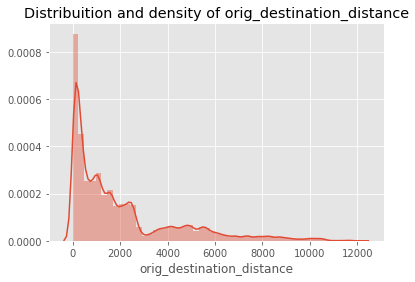

In [11]:
#Let's check distribution of orig_destination_distance before binning
dist_data = chunk1['orig_destination_distance']
dist_data = dist_data[~np.isnan(dist_data)]
sns.distplot(dist_data)
plt.title("Distribuition and density of orig_destination_distance")
plt.xlabel("orig_destination_distance")

In [15]:
#Create columns with combined user location and destination ids 
chunk1['typ_contnt_cntry_mkt_id']=chunk1[['srch_destination_type_id', 'hotel_continent','hotel_country','hotel_market']].astype(str).sum(axis=1)
chunk1['user_country_region_city']=chunk1[['user_location_country','user_location_region','user_location_city']].astype(str).sum(axis=1)
chunk1['user_dest_ids']=chunk1[['user_location_country','user_location_region','user_location_city','srch_destination_type_id', 'hotel_continent','hotel_country','hotel_market']].astype(str).sum(axis=1)
print(len(chunk1['typ_contnt_cntry_mkt_id'].unique()))
print(len(chunk1['user_country_region_city'].unique()))
len(chunk1['user_dest_ids'].unique())

7222
15186


174359

In [19]:
user_dest_ids = chunk1['user_dest_ids'].unique()
dists = chunk1[chunk1['user_dest_ids']==user_dest_ids[10000]]['orig_destination_distance']
dists.isnull().sum()

0

In [29]:
#checking which user_dest_id has the max and least percent nans amongst the one that have nans
# user_dest_ids = chunk1['user_dest_ids'].unique()
nan_dists_by_user_dest_ids=[]#={}
# test={}
for i in user_dest_ids:
    dists = chunk1[chunk1['user_dest_ids']==i]['orig_destination_distance']
    try:
        nan_dists_by_user_dest_ids.append((dists.isnull().sum()/len(dists))*100.0)
#         test[i]==(dists.isnull().sum()/len(dists))*100
    except:
        pdb.set_trace()

Text(0.5,0,'NANs in orig_destination_distance grouped by user locations and destn ids')

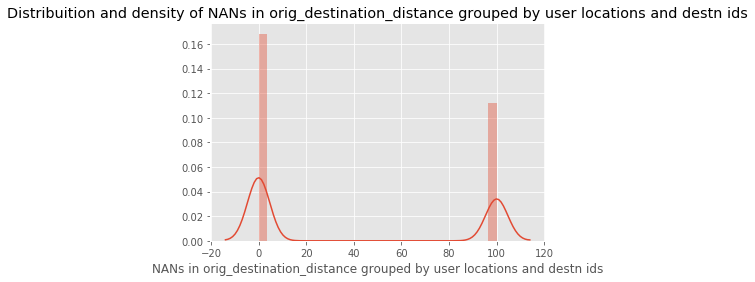

In [30]:
sns.distplot(nan_dists_by_user_dest_ids)
plt.title("Distribuition and density of NANs in orig_destination_distance grouped by user locations and destn ids")
plt.xlabel("NANs in orig_destination_distance grouped by user locations and destn ids")

In [31]:
d={'user_dest_ids':user_dest_ids,'NanRatio_dists_by_user_dest_ids':nan_dists_by_user_dest_ids}
df=pd.DataFrame(data=d)
df[df['NanRatio_dists_by_user_dest_ids']>0.0]

,NanRatio_dists_by_user_dest_ids,user_dest_ids
3,100.0,6.634850e+16
4,100.0,6.634850e+16
14,100.0,6.634835e+16
15,100.0,2.348492e+14
16,100.0,2.348492e+15
17,100.0,2.348492e+14
18,100.0,2.348492e+14
19,100.0,2.363535e+17
20,100.0,2.348492e+14
21,100.0,6.629319e+16


One can see above that the origin to destination values that are Nan are fully missing in the data set. Let's see if this holds just for country to country

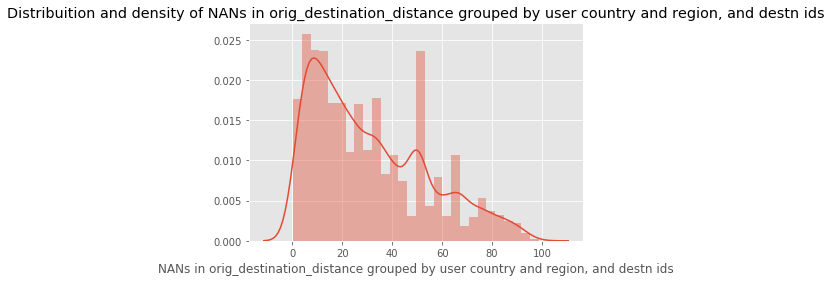

In [59]:
# # chunk1['user_country_region_dest_ids']=chunk1[['user_location_country','user_location_region','srch_destination_type_id', 'hotel_continent','hotel_country','hotel_market']].astype(str).sum(axis=1)
# # user_dest_ids = chunk1['user_country_region_dest_ids'].unique()
# # print(len(user_dest_ids))
# NanRatio=[]#={}
# for i in user_dest_ids:
#     dists = chunk1[chunk1['user_country_region_dest_ids']==i]['orig_destination_distance']
#     try:
#         NanRatio.append((dists.isnull().sum()/len(dists))*100.0)
#     except:
#         pdb.set_trace()
# d={'user_dest_ids':user_dest_ids,'NanRatio_Percent':NanRatio}
# df=pd.DataFrame(data=d)
# print(df[df['NanRatio_Percent']>0.0])
# nob_zero_nans = df[df['NanRatio_Percent']>0.0]
# sns.distplot(df[(df['NanRatio_Percent']>0.0)]['NanRatio_Percent'])
# plt.title("Distribuition and density of NANs in orig_destination_distance grouped by user country and region, and destn ids")
# plt.xlabel("NANs in orig_destination_distance grouped by user country and region, and destn ids")
# plt.show()
sns.distplot(df[(df['NanRatio_Percent']>0.0) & (df['NanRatio_Percent']<100.0)]['NanRatio_Percent'])
plt.title("Distribuition and density of NANs in orig_destination_distance grouped by user country and region, and destn ids")
plt.xlabel("NANs in orig_destination_distance grouped by user country and region, and destn ids")
plt.show()

Since the percentage of NANs varies for different origin (country+region) and destinations, it is best to use a smart method to substitue the missing values such that the distribution of orgin-destination_distance for these origin-dest pairs is not dirupted. We use the following methods:
1) SMOTE
2) 

#### Is data balanced?

In [87]:
x=len(chunk1[chunk1['is_booking']==0])
print("Data points with 0 bookings: "+str(x))
print("Data points with 1 bookings: "+str(1e6-x))
print("Imbalance factor: "+str(round(x/(1e6-x),2)))

Data points with 0 bookings: 919016
Data points with 1 bookings: 80984.0
Imbalance factor: 11.35


One option is to simply undersample. So remove 0 booking points such that 0 booking is equal to 1 booking.

Note:
- Points should be removed in such a way that points corresponding to the same user id are either or fully removed or fully intact.
- During this elimnation, preference should be given to elimnating points with orig_destination_dist values missing.

In [96]:
clstrs=np.unique(chunk1['hotel_cluster'])
reqd_pts=1e6/100
print('In 100 clusters and 1e6 sample points, points per cluster should be: ',reqd_pts,'\n')
print('cluster, pts, percent of sample size','sample shortage')
for c in clstrs:
    pts_present=len(chunk1[chunk1['hotel_cluster']==c])
    print(c,pts_present,round(pts_present*100/1e6,2),reqd_pts-pts_present)

In 100 clusters and 1e6 sample points, points per cluster should be:  10000.0 

cluster, pts, percent of sample size sample shortage
0 9951 1.0 49.0
1 11636 1.16 -1636.0
2 11971 1.2 -1971.0
3 5797 0.58 4203.0
4 9020 0.9 980.0
5 16374 1.64 -6374.0
6 9878 0.99 122.0
7 6780 0.68 3220.0
8 8445 0.84 1555.0
9 12881 1.29 -2881.0
10 10548 1.05 -548.0
11 9578 0.96 422.0
12 7109 0.71 2891.0
13 8815 0.88 1185.0
14 5122 0.51 4878.0
15 8618 0.86 1382.0
16 12538 1.25 -2538.0
17 8992 0.9 1008.0
18 14470 1.45 -4470.0
19 7156 0.72 2844.0
20 8161 0.82 1839.0
21 14440 1.44 -4440.0
22 7900 0.79 2100.0
23 6815 0.68 3185.0
24 4105 0.41 5895.0
25 14269 1.43 -4269.0
26 10325 1.03 -325.0
27 2865 0.29 7135.0
28 13269 1.33 -3269.0
29 11209 1.12 -1209.0
30 13027 1.3 -3027.0
31 6610 0.66 3390.0
32 7698 0.77 2302.0
33 10702 1.07 -702.0
34 8217 0.82 1783.0
35 3640 0.36 6360.0
36 11245 1.12 -1245.0
37 13098 1.31 -3098.0
38 7195 0.72 2805.0
39 8975 0.9 1025.0
40 11384 1.14 -1384.0
41 21005 2.1 -11005.0
42 14707 1.47 -

In [86]:
# #Function removes rows from data set corresponding to user_ids that occur more than once
# def smpl_split(df,verbose=False):
#     df1=df[df['is_booking']==0]
    
#     '''Amount of undersampling required'''
#     num_ones=len(df[df['is_booking']==1])
    
#     userdIds=np.unique(df['user_id'])
#     df2=pd.DataFrame(columns=np.array(df.columns))
#     df3=pd.DataFrame(columns=np.array(df.columns))
#     for u in userdIds:        
#         df1_sbst = df1[df1['user_id']==u]
#         if len(df1_sbst)==1:
#             df2.append(df1_sbst) 
#     '''dataset_with bookings that either have multiple entries by the same user or entries of a user who made a booking'''
#     df3 = pd.concat([df, df2], axis=1, join='outer')
#     if verbose:
#         print('Num zeros in df3:'+str(len(df3[df3['is_booking']==0])))
#         print('Num ones in df3:'+str(len(df3[df3['is_booking']==1])))
    
#     '''Remaining number of zeros required in the data set'''
#     num_zeros = num_ones - len(df3[df3['is_booking']==0])
# #     percent_zeros_required = (num_ones - len(df3[df3['is_booking']==0]))/num_ones
#     if verbose:
#         print('Num zeros required:'+str(num_zeros))
# #         print('Percent zeros required:'+str(percent_zeros_required))
    
#     '''sample remaining zeros here from df2 and append those points to df3'''
#     df3.append(df2.sample(n=num_zeros,replace=False))
#     if verbose:
#         print('Num zeros in df3:'+str(len(df3[df3['is_booking']==0])))
#         print('Num ones in df3:'+str(len(df3[df3['is_booking']==1])))
    
#     return df3

# chunk_undersampled = smpl_split(chunk1,verbose=True)           

ValueError: Boolean array expected for the condition, not float64

### 4) Classification models

- one hot encoding for un-ordered data
- labeling ordered data - (not needed in this case?)
- add date time columns later

TODO:

1) create intelleginet test-train split such that test contains single and multiple of some new customers not represented in train.
2) use date-time columns and number of days of stay using timedelta of datetime?

In [5]:
chunk12 = chunk1.drop(['orig_destination_distance'],axis=1)
print(chunk1.shape, chunk12.shape)
check_nan(chunk12)
chunk12 = chunk12.dropna(axis=0) #drop rows with 0s in other columns since they were only 0.02% of the data set
print(chunk12.shape)
check_nan(chunk12)

(1000000, 24) (1000000, 23)
          abs  ratio(%)
srch_ci  1304    0.1304
srch_co  1304    0.1304
(998696, 23)
Empty DataFrame
Columns: [abs, ratio(%)]
Index: []


,abs,ratio(%)
date_time,0,0.0
site_name,0,0.0
posa_continent,0,0.0
user_location_country,0,0.0
user_location_region,0,0.0
user_location_city,0,0.0
user_id,0,0.0
is_mobile,0,0.0
is_package,0,0.0
channel,0,0.0


In [98]:
#test train split
X=chunk12.iloc[:,:-1] #because last column is y
y=chunk12[[chunk12.columns[len(chunk12.columns)-1]]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
print(X_train.shape,X_test.shape)
print(len(y_train), len(y_test))
# print(X_train.columns)
# print(X_train.head())
# print(y_train.head())
# print(X_test.head())
# print(y_test.head())

(798956, 22) (199740, 22)
798956 199740


In [99]:
#one hot encoding
X_train.dtypes

date_time                   object
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_ci                     object
srch_co                     object
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
is_booking                   int64
cnt                          int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
dtype: object

In [7]:
cols = X_train.columns
cat_cols = ['site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city','user_id', 
       'is_mobile', 'is_package', 'channel', 'srch_destination_id',
       'srch_destination_type_id','is_booking','hotel_continent',
       'hotel_country', 'hotel_market']#categorical cols
time_cols = ['date_time','srch_ci', 'srch_co',]
count_cols = ['srch_adults_cnt', 'srch_children_cnt',
              'srch_rm_cnt','cnt',]
cts_cols = ['orig_destination_distance']

In [101]:
time_data = X_train[time_cols]
time_data.head()

,date_time,srch_ci,srch_co
1521148,2013-06-20 17:53:01,2013-09-26,2013-09-29
1216069,2013-07-19 20:03:31,2013-07-20,2013-07-21
1061206,2014-08-07 09:30:07,2014-09-26,2014-09-30
1022895,2013-05-27 18:13:23,2013-07-06,2013-07-08
1898177,2014-12-27 13:15:43,2015-06-05,2015-06-06


In [58]:
# print(type(time_data['date_time'].iloc[0]))
# print(int(time_data['date_time'].iloc[0][:4]))
# print(int(time_data['date_time'].iloc[0][5:7]))
# print(int(time_data['date_time'].iloc[0][8:10]))
# print(int(time_data['date_time'].iloc[0][11:13]))
# print(int(time_data['date_time'].iloc[0][14:16]))
# print(int(time_data['date_time'].iloc[0][17:19]))
# print(int(time_data['srch_ci'].iloc[0][:4]))
# print(int(time_data['srch_ci'].iloc[0][5:7]))
# print(int(time_data['srch_ci'].iloc[0][8:10]))
# print(int(time_data['srch_co'].iloc[0][:4]))
# print(int(time_data['srch_co'].iloc[0][5:7]))
# print(int(time_data['srch_co'].iloc[0][8:10]))
# import pdb
# def add_date_time_cols(df,col_name,time_col=False):
#     df[col_name+"_yr"] = [int(date_time[:4]) for date_time in df[col_name]]
#     df[col_name+"_mnth"] = [int(date_time[5:7]) for date_time in df[col_name]]
#     df[col_name+"_day"] = [int(date_time[8:10]) for date_time in df[col_name]]
#     pdb.set_trace()
#     if time_col:     
#         df[col_name+"_hr"] = [int(date_time[11:13]) for date_time in df[col_name]]
#         df[col_name+"_min"] = [int(date_time[14:6]) for date_time in df[col_name]]
#         df[col_name+"_sec"] = [int(date_time[17:19]) for date_time in df[col_name]]
#     return df    

# for col in time_cols:
#     time_col=False
#     if col=='date_time':
#         time_col=True
#     X_train = add_date_time_cols(X_train,col,time_col=time_col)
#     X_test = add_date_time_cols(X_test,col,time_col=time_col)
#     print(X_train[col+"yr"][:5])

<class 'str'>
2013
3
18
12
5
55
2013
6
13
2013
6
18


In [107]:
from datetime import datetime
from dateutil.parser import parse
X_train['date_time'] = pd.to_datetime(X_train['date_time'])
X_train['srch_ci'] = [parse(x) for x in X_train['srch_ci']]
X_train['srch_co'] = [datetime.strptime(x, '%Y-%m-%d') for x in X_train['srch_co']]
X_train.dtypes

C:\Anaconda2\envs\cnn2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda2\envs\cnn2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda2\envs\cnn2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

date_time                   datetime64[ns]
site_name                            int64
posa_continent                       int64
user_location_country                int64
user_location_region                 int64
user_location_city                   int64
user_id                              int64
is_mobile                            int64
is_package                           int64
channel                              int64
srch_ci                             object
srch_co                             object
srch_adults_cnt                      int64
srch_children_cnt                    int64
srch_rm_cnt                          int64
srch_destination_id                  int64
srch_destination_type_id             int64
is_booking                           int64
cnt                                  int64
hotel_continent                      int64
hotel_country                        int64
hotel_market                         int64
dtype: object

In [26]:
#labeling

- No labeling or one-hot encoding needed.
- dropping all time columns at the moment.
- modeling below without any date-time columns

In [115]:
[1,2,3]+[6,7,8]

[1, 2, 3, 6, 7, 8]

In [8]:
X_train = X_train[cat_cols+count_cols]
X_test = X_test[cat_cols+count_cols]

#### logistic regression

In [117]:
from sklearn.linear_model import LogisticRegression

In [ ]:
t=time.time()
logModel = LogisticRegression()
logModel.fit(X_train, y_train)
y_pred = logModel.predict(X_test)
print(classification_report(y_test, y_pred))
print("R squared: "+str(r2_score(y_test, y_pred)))
print("Time taken: "+str(time.time()-t)+"secs")

C:\Anaconda2\envs\cnn2\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### naive bayes

In [11]:
t=time.time()
print("Time taken: "+str(time.time()-t)+"secs")

Time taken: 0.0secs


#### svm

In [ ]:
t=time.time()
print("Time taken: "+str(time.time()-t)+"secs")

#### RFC

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
t=time.time()
clf = RandomForestClassifier(n_estimators=100,max_depth=15, random_state=0)
clf.fit(X_train, y_train)
print("Time taken: "+str(round(time.time()-t,2))+"secs")

C:\Anaconda2\envs\cnn2\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Time taken: 324.87secs


In [22]:
t=time.time()
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("R squared: "+str(r2_score(y_test, y_pred)))
print("Time taken: "+str(round(time.time()-t,2))+"secs")

             precision    recall  f1-score   support

          0       0.19      0.41      0.26      1976
          1       0.27      0.95      0.43      2343
          2       0.20      0.21      0.21      2378
          3       0.45      0.05      0.09      1150
          4       0.18      0.10      0.13      1801
          5       0.15      0.14      0.14      3196
          6       0.34      0.05      0.09      1986
          7       0.44      0.05      0.10      1376
          8       0.27      0.37      0.31      1643
          9       0.22      0.13      0.17      2511
         10       0.30      0.10      0.15      2069
         11       0.23      0.10      0.14      1968
         12       0.24      0.27      0.26      1402
         13       0.37      0.04      0.08      1846
         14       0.38      0.04      0.07      1037
         15       0.29      0.09      0.13      1751
         16       0.29      0.06      0.10      2477
         17       0.30      0.05      0.09   

In [27]:
# grid search params
grid_times = {}
for number in np.arange(2, 600, 50):
    
    param = np.arange(1,number,10)
    param_grid = {"n_estimators": param,
                  "criterion": ["gini", "entropy"]}
    
    grid_search = GridSearchCV(clf, param_grid = param_grid)
    
    t0 = time.time()
    grid_search.fit(X_train, y_train)
    compute_time = time() - t0
    grid_times[len(grid_search.grid_scores_)] = time.time() - t0
    
grid_times = pd.DataFrame.from_dict(grid_times, orient = 'index')


IndexError: too many indices for array

In [42]:
def evaluate_param(parameter, num_range, index):
    pdb.set_trace()
    grid_search = GridSearchCV(clf, param_grid = {parameter: num_range})
    grid_search.fit(X_train, y_train)
    
    df = {}
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
           
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(3,2,index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    return plot, df

In [36]:
# parameters and ranges to plot
param_grid = {"n_estimators": np.arange(2, 300, 2),
              "max_depth": np.arange(1, 28, 1),
              "min_samples_split": np.arange(1,150,1),
              "min_samples_leaf": np.arange(1,60,1),
              "max_leaf_nodes": np.arange(2,60,1),
              "min_weight_fraction_leaf": np.arange(0.1,0.4, 0.1)}

In [ ]:
index = 1
plt.figure(figsize=(16,12))
for parameter, param_range in dict.items(param_grid):
    evaluate_param(parameter, param_range, index)
    index += 1

> <ipython-input-42-596ce3827bcc>(3)evaluate_param()
-> grid_search = GridSearchCV(clf, param_grid = {parameter: num_range})
(Pdb) grid_search = GridSearchCV(clf, param_grid = {parameter: num_range})
(Pdb) n
> <ipython-input-42-596ce3827bcc>(4)evaluate_param()
-> grid_search.fit(X_train, y_train)
(Pdb) n
IndexError: too many indices for array
> <ipython-input-42-596ce3827bcc>(4)evaluate_param()
-> grid_search.fit(X_train, y_train)
(Pdb) grid_search.fit(X_train.iloc[:,0:5], y_train)
*** IndexError: too many indices for array
(Pdb) grid_search.fit(X_train, y_train.flatten())
*** AttributeError: 'DataFrame' object has no attribute 'flatten'
(Pdb) grid_search.fit(X_train, y_train.ravel())
*** AttributeError: 'DataFrame' object has no attribute 'ravel'
(Pdb) type(y_train)
<class 'pandas.core.frame.DataFrame'>
(Pdb) y_train.shape
(798956, 1)
(Pdb) type(y_train[0].values)
*** KeyError: 0
(Pdb) type(y_train.values)
<class 'numpy.ndarray'>
(Pdb) grid_search.fit(X_train, y_train.values)
*** Inde

In [44]:
print(clf.feature_importances_)

[ 0.02759215  0.01712367  0.03483694  0.06269226  0.06543519  0.07802732
  0.01122181  0.02118161  0.03250752  0.16302095  0.0321617   0.00691578
  0.06830394  0.100876    0.18464571  0.02863071  0.02261006  0.01134101
  0.03087567]


#### XGBoost

In [ ]:
t=time.time()
print("Time taken: "+str(round(time.time()-t,2))+"secs")

#### neural nets

In [ ]:
t=time.time()
print("Time taken: "+str(round(time.time()-t,2))+"secs")

# Assembly model

**Note**: Ignore orig_dest_dist column for now

1) Cluster as 5,10,15 (make elbow curve)

2) Build SVM on these cluster labels

3) USe SVM weights as features of each sample point. Create a new data set for each sample point with these features and feed to NN. 

4) Check Classificantion Report: Precision & Recall

------
**FIX:**

1) Inner join will lead to model to being able to work with new hotels. 

2) How do we create the dummy variables? Do we put the rare occuring variables as other?

3) Missing data in orig_dest_distance

4) Split time data as day,month, year

5) Add number of times that user searched on the webiste including the time the user booked

6) The picture

7) Add feature called difference of two dates

In [2]:
# chunk1=pd.read_pickle('train_sample_0.pickle')
full_df=pd.read_csv('subset.csv')
# full_df=df
df=full_df.drop(['orig_destination_distance'],axis=1)
df=df.dropna(axis=0)

In [3]:
df=df[:100000]
df.shape

(1000000, 23)

In [7]:
df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 08:22:12,2,3,66,348,48862,12,0,1,9,2014-08-29,2014-09-02,2,0,1,8250,1,1,1,2,50,628,1
1,2014-02-27 18:01:32,2,3,66,318,52078,756,0,1,4,2014-04-18,2014-04-20,2,0,1,8291,1,1,1,2,50,191,2
2,2013-06-15 15:38:05,30,4,195,548,56440,1048,0,1,9,2013-09-06,2013-09-14,2,0,1,1385,1,1,1,0,185,185,58
3,2014-11-23 18:02:20,30,4,195,991,47725,1048,0,0,9,2015-06-26,2015-06-28,2,0,1,8803,1,1,1,3,151,69,36
4,2014-01-03 16:30:17,2,3,66,462,41898,1482,0,1,1,2014-02-22,2014-02-27,3,0,2,12009,1,1,1,2,50,680,95


In [7]:
destdf = pd.read_pickle('destinations.pickle')
destdf.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45,d46,d47,d48,d49,d50,d51,d52,d53,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63,d64,d65,d66,d67,d68,d69,d70,d71,d72,d73,d74,d75,d76,d77,d78,d79,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100,d101,d102,d103,d104,d105,d106,d107,d108,d109,d110,d111,d112,d113,d114,d115,d116,d117,d118,d119,d120,d121,d122,d123,d124,d125,d126,d127,d128,d129,d130,d131,d132,d133,d134,d135,d136,d137,d138,d139,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.043789,-2.181690,-2.181690,-2.181690,-2.165028,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.165028,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.181690,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,-2.224164,-2.209855,-2.224164,-2.110723,-2.186008,-2.224164,-2.124474,-2.224164,-2.156467,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.153316,-2.186008,-2.224164,-2.224164,-2.224164,-2.128237,-2.158309,

In [ ]:
df['month']=pd.to_datetime(df['date_time']).dt.month
df['day']=pd.to_datetime(df['date_time']).dt.day
df['year']=pd.to_datetime(df['date_time']).dt.year
t2 = pd.to_datetime(df['srch_co'])
t1 = pd.to_datetime(df['srch_ci'])
df['stay_duration']=(t2-t1).dt.days
df=df.merge(destdf, how='inner', on='srch_destination_id')
df.to_pickle("subset_chunk1_merged.pickle")
print(df.shape)
# X_full.head()
X_full=df.drop(['hotel_cluster','date_time','srch_co','srch_ci','is_booking'],axis=1) #because last column is y
y_full=df['hotel_cluster']

In [10]:
k = set(np.unique(df['srch_destination_id'])) - set(np.unique(destdf['srch_destination_id']))
print(len(np.unique(df['srch_destination_id'])))
print(len(k))

36933
595


In [11]:
df=pd.read_pickle('subset_chunk1_merged.pickle')
X_full=df.drop(['hotel_cluster','date_time','srch_co','srch_ci','is_booking'],axis=1) #because last column is y
y_full=df['hotel_cluster'][:]
print(X_full.shape)
len(y_full)

(100000, 171)


100000

In [23]:
check_nan(X_full) 

Empty DataFrame
Columns: [abs, ratio(%)]
Index: []


,abs,ratio(%)
site_name,0,0.0
posa_continent,0,0.0
user_location_country,0,0.0
user_location_region,0,0.0
user_location_city,0,0.0
user_id,0,0.0
is_mobile,0,0.0
is_package,0,0.0
channel,0,0.0
srch_adults_cnt,0,0.0


In [61]:
for col in list(X_full.columns)[22:]:
    vals=X_full[col][:50000]
    l=len(np.unique(vals))
    if l==1:
        print(col,l,min(vals),max(vals))

d1 1 -2.28394551216 -2.28394551216
d2 1 -2.34664515004 -2.34664515004
d3 1 -2.40091211081 -2.40091211081
d4 1 -2.36719027495 -2.36719027495
d5 1 -2.27322643159 -2.27322643159
d6 1 -1.72286779969 -1.72286779969
d7 1 -2.39286246081 -2.39286246081
d8 1 -2.38138746213 -2.38138746213
d9 1 -2.23927138165 -2.23927138165
d10 1 -2.25926567168 -2.25926567168
d11 1 -2.30573070404 -2.30573070404
d12 1 -2.40091211081 -2.40091211081
d13 1 -2.36954529746 -2.36954529746
d14 1 -1.7122768602 -1.7122768602
d15 1 -2.39946739327 -2.39946739327
d16 1 -1.90155309131 -1.90155309131
d17 1 -2.0655345969 -2.0655345969
d18 1 -2.38467151033 -2.38467151033
d19 1 -2.39964930792 -2.39964930792
d20 1 -1.14006604761 -1.14006604761
d21 1 -2.35454487344 -2.35454487344
d22 1 -2.40059631848 -2.40059631848
d23 1 -2.40091211081 -2.40091211081
d24 1 -2.36518334196 -2.36518334196
d25 1 -2.39743459511 -2.39743459511
d26 1 -2.36533093656 -2.36533093656
d27 1 -2.39798117894 -2.39798117894
d28 1 -2.36363035354 -2.36363035354
d29 1

In [62]:
len_data=1000000
X=X_full[:len_data]
y=y_full[:len_data]
print(X.shape,len(y))
print(y[:10])
X.head()

(1000000, 171) 1000000
0     1
1     1
2    45
3     1
4    19
5    88
6    91
7     1
8    24
9    45
Name: hotel_cluster, dtype: int64


,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,cnt,hotel_continent,hotel_country,hotel_market,month,day,year,stay_duration,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45,d46,d47,d48,d49,d50,d51,d52,d53,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63,d64,d65,d66,d67,d68,d69,d70,d71,d72,d73,d74,d75,d76,d77,d78,d79,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100,d101,d102,d103,d104,d105,d106,d107,d108,d109,d110,d111,d112,d113,d114,d115,d116,d117,d118,d119,d120,d121,d122,d123,d124,d125,d126,d127,d128,d129,d130,d131,d132,d133,d134,d135,d136,d137,d138,d139,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,2,3,66,348,48862,12,0,1,9,2,0,1,8250,1,1,2,50,628,8,11,2014,4,-2.283946,-2.346645,-2.400912,-2.36719,-2.273226,-1.722868,-2.392862,-2.381387,-2.239271,-2.259266,-2.305731,-2.400912,-2.369545,-1.712277,-2.399467,-1.901553,-2.065535,-2.384672,-2.399649,-1.140066,-2.354545,-2.400596,-2.400912,-2.365183,-2.397435,-2.365331,-2.397981,-2.36363,-1.675819,-2.194497,-2.400912,-2.399802,-2.398695,-2.392615,-2.209667,-2.317894,-1.281688,-2.398314,-2.37445,-2.370005,-2.031847,-2.38759,-1.645141,-2.400912,-2.37857,-2.364266,-2.397885,-2.355131,-1.349492,-2.3731,-2.3975,-2.348903,-2.241532,-2.400534,-2.207067,-2.305964,-2.397016,-2.241567,-2.393153,-2.399966,-2.38017,-2.391761,-2.399015,-2.400506,-2.400912,-2.363137,-2.395585,-2.396456,-2.391947,-2.400912,-2.356842,-2.379234,-2.393781,-1.967871,-1.960995,-2.399409,-2.333032,-2.38558,-2.257085,-2.316076,-2.39186,-2.397906,-2.372328,-2.079968,-2.220271,-2.400912,-2.399502,-2.387979,-2.392953,-2.400396,-1.938336,-2.396843,-1.366535,-2.381904,-2.396208,-2.306028,-2.399802,-2.398006,-2.385102,-2.400912,-2.387891,-2.340923,-2.359161,-2.336553,-2.364671,-2.396077,-2.280828,-1.760466,-2.371376,-2.389435,-2.36865,-2.392657,-2.397517,-2.356602,-2.399802,-2.397591,-2.39211,-2.394294,-2.398695,-2.392041,-1.925548,-1.868743,-2.400912,-2.389131,-2.390027,-2.363872,-2.396035,-2.007101,-2.400837,-2.120344,-2.27519,-2.203799,-2.373795,-2.365093,-2.400912,-2.370761,-2.343093,-2.320423,-1.73264,-2.384553,-2.345528,-2.396591,-2.399953,-2.388116,-2.394294,-2.400667,-2.398716,-2.386585,-2.39037
1,13,1,46,171,15334,4539,0,0,9,2,2,1,8250,1,2,2,50,628,11,20,2013,2,-2.283946,-2.346645,-2.400912,-2.36719,-2.273226,-1.722868,-2.392862,-2.381387,-2.239271,-2.259266,-2.305731,-2.400912,-2.369545,-1.712277,-2.399467,-1.901553,-2.065535,-2.384672,-2.399649,-1.140066,-2.354545,-2.400596,-2.400912,-2.365183,-2.397435,-2.365331,-2.397981,-2.36363,-1.675819,-2.194497,-2.400912,-2.399802,-2.398695,-2.392615,-2.209667,-2.317894,-1.281688,-2.398314,-2.37445,-2.370005,-2.031847,-2.38759,-1.645141,-2.400912,-2.37857,-2.364266,-2.397885,-2.355131,-1.349492,-2.3731,-2.3975,-2.348903,-2.241532,-2.400534,-2.207067,-2.305964,-2.397016,-2.241567,-2.393153,-2.399966,-2.38017,-2.391761,-2.399015,-2.400506,-2.400912,-2.363137,-2.395585,-2.396456,-2.391947,-2.400912,-2.356842,-2.379234,-2.393781,-1.967871,-1.960995,-2.399409,-2.333032,-2.38558,-2.257085,-2.316076,-2.39186,-2.397906,-2.372328,-2.079968,-2.220271,-2.400912,-2.399502,-2.387979,-2.392953,-2.400396,-1.938336,-2.396843,-1.366535,-2.381904,-2.396208,-2.306028,-2.399802,-2.398006,-2.385102,-2.400912,-2.387891,-2.340923,-2.359161,-2.336553,-2.364671,-2.396077,-2.280828,-1.760466,-2.371376,-2.389435,-2.36865,-2.392657,-2.397517,-2.356602,-2.399802,-2.397591,-2.39211,-2.394294,-2.398695,-2.392041,-1.925548,-1.868743,-2.400912,-2.389131,-2.390027,-2.363872,-2.396035,-2.007101,-2.400837,-2.120344,-2.27519,-2.203799,-2.373795,-2.365093,-2.400912,-2.370761,-2.343093,-2.320423,-1.73264,-2.384553,-2.345528,-2.396591,-2.399953,-2.388116,-2.394294,-2.400667,-2.398716,-2.386585,-2

(800000, 171) (200000, 171)
800000 200000
        site_name  posa_continent  user_location_country  \
903243          2               3                     66   
821016         32               1                     62   
199878         10               0                    182   
231265          2               3                      3   
285836          2               3                     66   

        user_location_region  user_location_city  user_id  is_mobile  \
903243                   220                1437    82962          0   
821016                    31               22157  1001276          0   
199878                   416               32100  1115617          0   
231265                    64                3169   919546          0   
285836                   174               41922   812607          0   

        is_package  channel  srch_adults_cnt  srch_children_cnt  srch_rm_cnt  \
903243           0        9                2                  0            1   
8210

In [73]:
catvars = ['site_name','posa_continent','user_location_country','user_location_region','user_location_city',
           'srch_destination_id','srch_destination_type_id' ,'hotel_continent' ,'hotel_country' ,'hotel_market']
for col in catvars:
    print(col,len(np.unique(df[col])))

site_name 42
posa_continent 5
user_location_country 170
user_location_region 676
user_location_city 7937
srch_destination_id 8741
srch_destination_type_id 5
hotel_continent 6
hotel_country 168
hotel_market 1819


In [94]:
def change_catvars_to_others(df,catvars,numlevels):
    data=copy.copy(df)
    len_data = len(data)
    for col in catvars:
        num_others=0 
        if len(np.unique(data[col]))>numlevels:
            dtemp=data[col].value_counts()
            dtemp=dtemp.sort_values(axis=0, ascending=False)
    #         print(pd.DataFrame(dtemp))
            keep_vals=list(dtemp[:numlevels].index)
    #         print(keep_vals)
            vals_to_others = set(np.unique(df[col])) - set(keep_vals)
            data.loc[:,col].replace(list(vals_to_others), ['others']*len(list(vals_to_others)), inplace=True)
    #         pdb.set_trace()
            num_others=len(data[data[col]=='others'])
        print(col,num_others,num_others*100/len_data)
    return data

In [95]:
numlevels = 10
df2=change_catvars_to_others(df=df,catvars=catvars,numlevels=numlevels)  

site_name 3828 4.684975767366721
posa_continent 0 0.0
user_location_country 10654 13.039114896950116
user_location_region 49981 61.17026484554756
user_location_city 74192 90.80139031673765
srch_destination_id 72286 88.4686933959955
srch_destination_type_id 0 0.0
hotel_continent 0 0.0
hotel_country 16512 20.208547510647673
hotel_market 64786 79.28966563861556


In [67]:
a=[1,2,3,1,2,3,1,2,1,1]
b=[4,5,5,5,4,4,4,4,5,4]
c=pd.DataFrame({'a':a,'b':b})
dtemp=c['a'].value_counts()
print(dtemp)
# print(type(dtemp))
dtemp=dtemp.sort_values(axis=0, ascending=False)
# print(dtemp)
# print(pd.DataFrame(dtemp))
print(dtemp[:2])
keep_vals=list(dtemp[:2].index)
print(keep_vals)
vals_to_others = set(np.unique(c['a'])) - set(keep_vals)
c.loc[:, 'a'].replace(list(vals_to_others), ['other']*len(list(vals_to_others)), inplace=True)

print(c)

1    5
2    3
3    2
Name: a, dtype: int64
1    5
2    3
Name: a, dtype: int64
[1, 2]
       a  b
0      1  4
1      2  5
2  other  5
3      1  5
4      2  4
5  other  4
6      1  4
7      2  4
8      1  5
9      1  4


In [ ]:
# for user in 
# usr_visit_count = 

In [42]:
a=[1,2,3,1,2,3]
b=[4,5,5,5,4,4]
c=pd.DataFrame({'a':a,'b':b})
print(c)
enc.fit(c)
onehotlabels = enc.transform(c).toarray()
print(onehotlabels.shape)
print(onehotlabels)

   a  b
0  1  4
1  2  5
2  3  5
3  1  5
4  2  4
5  3  4
(6, 5)
[[ 1.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  1.]
 [ 0.  0.  1.  0.  1.]
 [ 1.  0.  0.  0.  1.]
 [ 0.  1.  0.  1.  0.]
 [ 0.  0.  1.  1.  0.]]


#### One Hot Encoding 

In [18]:
d1 = pd.DataFrame({'A': ['a', 'b', 'a'], 'B': ['b', 'a', 'c'],'C': [1, 2, 3],'D': [1, 2, 3]})
d1['C']=d1['C'].astype(str)
pd.get_dummies(d1, prefix=list(d1.columns)[:3])

,D,A_a,A_b,B_a,B_b,B_c,C_1,C_2,C_3
0,1,1,0,0,1,0,1,0,0
1,2,0,1,1,0,0,0,1,0
2,3,1,0,0,0,1,0,0,1


In [42]:
# # pd.get_dummies(X_train)
# X1 = pd.get_dummies(X_train, prefix=list(X_train.columns))
# print(X1.shape)
# print(X1.head())

In [64]:
# enc = OneHotEncoder()
# enc.fit(X_train)
# onehotlabels = enc.transform(X_train).toarray()

### 1) Clustering k-means

In [12]:
catvars = ['site_name','posa_continent','user_location_country','user_location_region','user_location_city',
           'srch_destination_id','srch_destination_type_id' ,'hotel_continent' ,'hotel_country' ,'hotel_market']
rearranged_cols = catvars+list(set(X_full.columns.tolist())-set(catvars))
num_catvars = len(catvars)
num_vars = len(rearranged_cols)
X_full=X_full[rearranged_cols]
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=101)
X_train.to_pickle("X_train_subset_chunk1.pickle")
X_test.to_pickle("X_test_subset_chunk1.pickle")
y_train.to_pickle("y_train_subset_chunk1.pickle")
y_test.to_pickle("y_test_subset_chunk1.pickle")
print(X_train.shape,X_test.shape)
print(len(y_train), len(y_test))
X_kmeans = np.asmatrix(X_train.drop(catvars,axis=1))

(80000, 171) (20000, 171)
80000 20000


In [35]:
X_kmodes=np.asmatrix(X_train)

In [30]:
for col in ['site_name']:
    X_train[col]=X_train[col].astype(str)
print(type(X_train['site_name'].iloc[0]))
print(X_train['site_name'].iloc[0])
X_train.head()

<class 'str'>
24


C:\Anaconda2\envs\cnn2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,site_name,posa_continent,user_location_country,user_location_region,user_location_city,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market,d4,d14,d120,d57,d66,d135,d119,cnt,d148,d33,srch_adults_cnt,d75,d95,d58,d147,d127,d53,d70,d8,d109,d122,srch_rm_cnt,d45,d101,is_mobile,d26,d81,d113,d144,d44,d86,d55,d25,d54,d114,d60,d16,d1,d87,d100,d139,d130,d69,d107,channel,d71,d112,d56,d24,d20,d41,d74,d67,d123,d42,d73,d22,d68,d30,d48,d64,d77,d23,d61,d96,d116,d2,d59,d29,d72,d97,day,d131,d27,d49,d10,d9,d80,d28,d38,d79,d118,d7,d146,d102,d142,d76,d133,d62,d6,stay_duration,d19,d126,d17,d99,d63,d18,d129,d85,d51,d46,d134,d11,d65,d121,d84,d52,d105,d104,d145,d32,d143,d90,month,d98,d124,d3,d88,srch_children_cnt,d125,d43,d93,d35,d40,d13,d92,d15,user_id,d12,d34,d39,d94,d136,d137,d5,d89,d103,d21,d31,d111,d78,d110,d50,d47,year,d140,d83,d149,d106,d108,d117,d138,d141,d82,d132,d91,d36,d37,is_package,d115,d128
38823,24,2,3,64,12576,8803,1,3,151,69,-2.235883,-2.033865,-2.244161,-2.265921,-2.254105,-2.265921,-2.265921,1,-2.265921,-2.265921,1,-2.167088,-2.256707,-1.988140,-2.264935,-2.202061,-2.152402,-2.265921,-2.265921,-2.132128,-2.000125,1,-2.161540,-2.265289,0,-2.254218,-2.265921,-2.265921,-2.265921,-2.254600,-2.265921,-2.227441,-2.174574,-2.265921,-2.253571,-2.265921,-2.042272,-2.252985,-2.265921,-2.265109,-1.827340,-2.209451,-2.265289,-2.253599,9,-2.176736,-2.248578,-2.220606,-2.265917,-2.264659,-2.157694,-2.116389,-2.201418,-2.265921,-2.265601,-2.246719,-2.265921,-2.173927,-2.237423,-2.235893,-2.200383,-2.096329,-2.265921,-2.253713,-2.198767,-2.265921,-2.233293,-2.265921,-2.136429,-2.265921,-2.265289,13,-2.173635,-2.215712,-1.750610,-2.254906,-2.263863,-1.971713,-2.224111,-2.252985,-2.265289,-2.265921,-2.265921,-2.265921,-2.021045,-2.188037,-2.265921,-2.260903,-2.265921,-1.940680,3,-2.265289,-2.264939,-2.201674,-2.201667,-2.265921,-2.252832,-1.944056,-2.175265,-2.187953,-2.260808,-2.227041,-2.204170,-2.265921,-2.097694,-2.096649,-2.265863,-2.260800,-2.176422,-2.265921,-2.264659,-2.265921,-2.253823,1,-2.265921,-2.265921,-2.265921,-2.260360,0,-2.265921,-1.971119,-1.736053,-2.185684,-2.264029,-2.256010,-2.265921,-2.265921,699028,-2.265921,-2.133110,-2.265921,-2.202931,-2.253734,-2.150952,-1.933998,-2.265289,-2.132581,-2.265921,-2.265921,-2.264659,-2.007871,-2.265921,-2.228692,-2.264659,2014,-2.264659,-2.157985,-2.265921,-2.265921,-1.622980,-2.265921,-2.265921,-2.233329,-2.264659,-1.991657,-1.964700,-2.265921,-1.658572,0,-2.265289,-2.013408
78870,2,3,71,0,44923,8267,1,2,50,675,-2.238242,-1.888947,-2.294751,-2.337960,-2.206414,-2.356791,-2.353920,1,-2.356791,-2.355353,1,-2.012670,-2.355353,-1.884772,-2.353851,-2.353113,-2.121314,-2.356791,-2.189171,-2.158710,-1.912275,1,-2.163057,-2.308789,0,-2.274196,-2.226795,-2.355832,-2.337682,-2.260889,-2.356791,-2.268637,-2.270382,-2.356791,-2.287909,-2.356791,-1.778688,-2.322565,-2.253214,-2.356787,-1.583489,-1.739861,-2.349647,-2.356791,9,-2.285310,-2.167122,-2.286335,-2.282854,-2.354334,-2.237787,-1.977363,-2.257775,-2.356791,-2.346641,-2.145262,-2.320451,-2.332735,-2.272039,-2.331504,-2.343577,-2.198307,-2.356791,-2.351271,-2.273811,-2.356791,-2.356244,-2.353580,-1.707335,-2.343549,-2.356791,22,-2.308103,-2.225477,-1.724759,-2.213122,-2.296162,-1.873232,-2.315705,-2.356791,-2.336692,-2.356312,-2.262388,-2.356368,-2.258800,-2.356791,-2.354662,-2.272998,-2.356791,-1.624715,3,-2.356791,-2.350044,-2.073126,-2.347065,-2.356644,-2.342409,-2.331305,-2.292906,-2.337274,-2.342931,-2.356310,-2.203796,-2.356791,-2.238977,-2.078565,-2.323824,-2.323263,-2.355622,-2.355353,-2.353920,-2.356312,-2.355911,1,-2.356791,-2.352619,-2.356791,-2.238095,1,-2.331139,-1.801793,-1.436136,-2.157924,-2.344946,-2.272856,-2.356680,-2.356791,199635,-2.356791,-2.149010,-2.356791,-2.202367,-2.175680,-2.074331,-1.879221,-2.355353,-2.280651,-2.334461,-2.356791,-2.355832,-2.146674,-2.331914,-2.329423,-2.334625,2014,-2.355353,-2.294102,-2.294829,-2.355353,-1.680786,-2.356312,-2.356545,-2.310370,-2.353835,-1.897370,-2

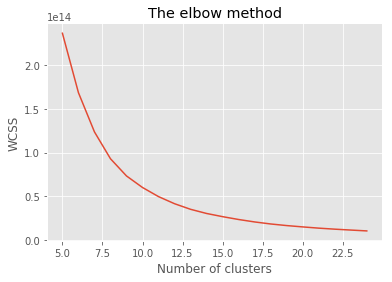

Time taken: 758.73secs


In [72]:
t=time.time()
wcss = []
x=X_kmeans[:50000]

clst_rng = np.arange(20)+5

for i in clst_rng:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(clst_rng, wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()
print("Time taken: "+str(round(time.time()-t,2))+"secs")

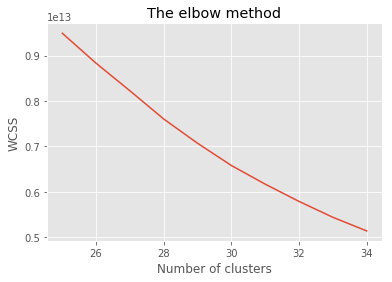

Time taken: 54769.0secs


In [73]:
t=time.time()
wcss = []
# x=X_kmeans[:50000]

clst_rng = np.arange(10)+25

for i in clst_rng:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(clst_rng, wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()
print("Time taken: "+str(round(time.time()-t,2))+"secs")

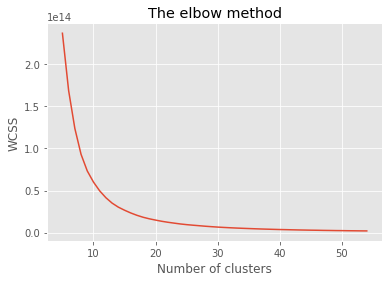

Time taken: 2812.47secs


In [75]:
t=time.time()
wcss = []
# x=X_kmeans[:50000]

clst_rng = np.arange(50)+5

for i in clst_rng:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(clst_rng, wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()
print("Time taken: "+str(round(time.time()-t,2))+"secs")

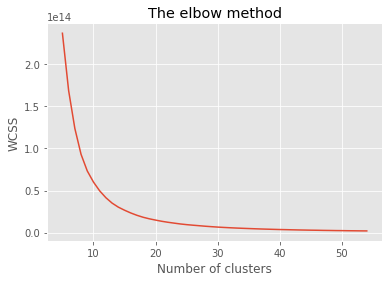

Time taken: 2812.47secs


In [75]:
t=time.time()
wcss = []
# x=X_kmeans[:50000]

clst_rng = np.arange(50)+5

for i in clst_rng:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(clst_rng, wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()
print("Time taken: "+str(round(time.time()-t,2))+"secs")

ValueError: x and y must have same first dimension, but have shapes (50,) and (52,)

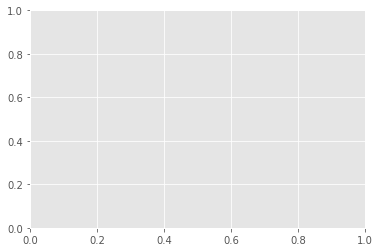

In [76]:
t=time.time()
n_clst=40
for max_iterations in [300,500]:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = max_iterations, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(clst_rng, wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()
print("Time taken: "+str(round(time.time()-t,2))+"secs")

In [ ]:
t=time.time()
n_clst=40
for max_iterations in [300,500]:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = max_iterations, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(clst_rng, wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()
print("Time taken: "+str(round(time.time()-t,2))+"secs")

In [33]:
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

In [31]:
num_catvars=len(catvars)

In [40]:
# x1=X_train[:1000].values
type(x1)

numpy.ndarray

In [42]:
K=30
kp_huang=KPrototypes(n_clusters=K, init='Huang', n_init=1, verbose=2)
kp_huang.fit(x1,categorical=list(range(0,num_catvars)))

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 192, ncost: 592376450517.4517
Run: 1, iteration: 2/100, moves: 131, ncost: 428160984169.92474
Run: 1, iteration: 3/100, moves: 91, ncost: 341126879100.6537
Run: 1, iteration: 4/100, moves: 43, ncost: 326430934835.7011
Run: 1, iteration: 5/100, moves: 24, ncost: 320322362388.03784
Run: 1, iteration: 6/100, moves: 26,

KPrototypes(cat_dissim=<function matching_dissim at 0x000001DABAA13B70>,
      gamma=27895.17548932977, init='Huang', max_iter=100, n_clusters=30,
      n_init=1,
      num_dissim=<function euclidean_dissim at 0x000001DABAA13BF8>,
      verbose=2)

In [43]:
kp_huang.cost_

242395608267.1077

In [38]:
kp_cao=KPrototypes(n_clusters=K, init='Cao', verbose=2)
kp_cao.fit_predict(X_train.values,categorical=list(range(0,num_catvars)))

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 18174, ncost: 21287176472599.887
Run: 1, iteration: 2/100, moves: 8549, ncost: 19172150661222.984
Run: 1, iteration: 3/100, moves: 5966, ncost: 18161816068641.453
Run: 1, iteration: 4/100, moves: 4739, ncost: 17477820325620.797
Run: 1, iteration: 5/100, moves: 3987, ncost: 16975170101756.07
Run: 1, iteration: 6/100, moves: 3515, ncost: 16534820410660.016
Run: 1, iteration: 7/100, moves: 3196, ncost: 16135936781379.059
Run: 1, iteration: 8/100, moves: 2967, ncost: 1

TypeError: unhashable type: 'slice'

In [ ]:
t1=time.time()

In [44]:
t=time.time()
km_huang=KModes(n_clusters=K, init='Huang', n_init=1, verbose=2)
km_huang.fit(X_train.values)
print("Time taken: "+str(round(time.time()-t,2))+"secs")

Init: initializing centroids
Init: initializing clusters


KeyboardInterrupt: 

In [ ]:
t=time.time()
km_huang_ng_dissim=KModes(n_clusters=K, init='Huang', cat_dissim=ng_dissim, n_init=1, verbose=2)
km_huang_ng_dissim.fit_predict(X_train)
print("Time taken: "+str(round(time.time()-t,2))+"secs")

In [ ]:
t=time.time()
km_cao=KModes(n_clusters=K, init='Cao', verbose=2)
km_cao.fit_predict(X_train)
print("Time taken: "+str(round(time.time()-t,2))+"secs")

In [ ]:
print("Time taken: "+str(round(time.time()-t1,2))+"secs")

# SVM

In [ ]:
# enc = OneHotEncoder()
# enc.fit(X_train)
# onehotlabels = enc.transform(X_train).toarray()

In [53]:
# # x2 = pd.get_dummies(X_train, prefix=list(catvars))
# # x2.to_pickle("subset_chunk1_dummies.pickle")
# x2=pd.read_pickle("subset_chunk1_dummies.pickle")
# x2.shape, X_train.shape

((80000, 9724), (80000, 171))

In [2]:
x2=pd.read_pickle("subset_chunk1_dummies.pickle")
y_train=pd.read_pickle("y_train_subset_chunk1.pickle")

In [3]:
from sklearn.svm import SVC

In [4]:
x2=x2.values

In [5]:
y_train=y_train.values

In [ ]:
clf = SVC(kernel='rbf',gamma=0.1,C=100,probability =True)
clf.set_params(kernel='linear').fit(x2,y_train)  
# y_pred=clf.predict(X_test)

In [ ]:
y_pred.shape

In [ ]:
print("R squared: "+str(r2_score(y_test, y_pred)))